1.) refit - done
2.) error - done
3.) construct amplitude weighted time for each event using the primary cluster and these offsets
4.) plot bbtime vs new HCal time
5.) hodoscope implementation

In [1]:
import ROOT as r
import math
import array
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
from scipy.optimize import curve_fit

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


Welcome to JupyROOT 6.26/06


In [2]:
pas="1"
config="3"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
#dymin=-.984
#dymax=.9
#W2max=1.75
#dybgmin=-1.2
#dybgmax=1.2
dxmin=-2
dxmax=1
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -2
dxmax: 1
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Coin Min: 88 Coin Max: 100


In [3]:
import ROOT as r


def list_branches(rootfile_path, tree_name="Tout"):
    # Open the ROOT file
    root_file = r.TFile.Open(rootfile_path)
    
    # Check if the file was successfully opened
    if not root_file or root_file.IsZombie():
        print(f"Error: Could not open ROOT file '{rootfile_path}'.")
        return
    
    # Access the TTree
    tree = root_file.Get(tree_name)
    
    # Check if the tree exists
    if not tree:
        print(f"Error: Tree '{tree_name}' not found in file '{rootfile_path}'.")
        root_file.Close()
        return
    
    # Get the list of branches
    branch_list = tree.GetListOfBranches()
    
    # Print all branch names
    print(f"Branches in tree '{tree_name}':")
    for branch in branch_list:
        print(branch.GetName())
    
    # Close the ROOT file
    root_file.Close()

# Example usage
rootfile_path = "../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
list_branches(rootfile_path)


Branches in tree 'Tout':
runnum
WCut
pCut
nCut
fiduCut
coinCut
ebeam
nu
Q2
W2
dpel
ephi
etheta
pcentral
vz
vx
vy
xtgt
ytgt
thtgt
phtgt
thetabend
xfp
yfp
thfp
phfp
trP
trPx
trPy
trPz
ePS
xPS
eSH
xSH
ySH
eHCAL
xHCAL
yHCAL
xHCAL_exp
yHCAL_exp
dx
dy
ngrinch_hits
xGRINCH
yGRINCH
coin_time
hcal_time
bbcal_time
BPMAx
BPMAy
Rasterx
Rastery
Raster2x
Raster2y
helicity
IHWP
pblkid
tdc
atime
nblk
mag
run
tar
cblkid
cblkatime
cblktime
cblke
nclus
cid
cx
cy
catime
hodoTimes
hodoIDs
hodoTOT
nbars


Error in <TList::Clear>: A list is accessing an object (0xa317ee0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x6298a20) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x6298e50) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa3699c0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa369d30) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa36a0a0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa36a5d0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa36a990) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa36b2f0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa36b6e0) alread

In [77]:

import ROOT as r
import math
import array
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
from scipy.optimize import curve_fit

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend

pas="1"
config="3"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
#dymin=-.984
#dymax=.9
#W2max=1.75
#dybgmin=-1.2
#dybgmax=1.2
dxmin=-2
dxmax=1
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')


def Load_Hodo(config,chunk_size=100000):
    rootfile = f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
    #rootfile = f"../outfiles/oldhcal.root"
    rootfile2=f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_p_model1.root"
    C = r.TChain("Tout")
    C.Add(rootfile)
    C.SetBranchStatus("*", 0)
   
    
    #HCAL VARS_____________________________________
    C.SetBranchStatus("cx", 1)
    C.SetBranchStatus("cy", 1)
    C.SetBranchStatus("cblktime",1)
    C.SetBranchStatus("cblkatime",1)
    C.SetBranchStatus("cblkid",1)
    C.SetBranchStatus("cblke",1)
    C.SetBranchStatus("tdc",1)
    C.SetBranchStatus("atime",1)
    C.SetBranchStatus("bbcal_time",1)
    C.SetBranchStatus("pblkid",1)
    C.SetBranchStatus("nclus",1)
    C.SetBranchStatus("nblk",1)
    C.SetBranchStatus("hodoTimes",1)
    C.SetBranchStatus("hodoIDs",1)
    C.SetBranchStatus("nbars",1)
    
    bbtime=array.array('d',[0])
    tdc=array.array('d',[0])
    atime=array.array('d',[0])
    pblkid=array.array('d',[0])
    cx = array.array('d', [0]*10) 
    cy = array.array('d', [0]*10) 
    cblktime=array.array('d',[0]*25)
    cblkatime=array.array('d',[0]*25)
    cblkid=array.array('d',[0]*25)
    cblke=array.array('d',[0]*25)
    nclus=array.array('d',[0])
    nblk=array.array('i',[0])
    hodoIDs=array.array('d',[0]*6)
    hodoTimes=array.array('d',[0]*6)
    nbars=array.array('i',[0])
    
    C.SetBranchAddress("cx", cx)
    C.SetBranchAddress("cy", cy)
    C.SetBranchAddress("cblktime",cblktime)
    C.SetBranchAddress("cblkatime",cblkatime)
    C.SetBranchAddress("cblkid",cblkid)
    C.SetBranchAddress("cblke",cblke)
    C.SetBranchAddress("tdc",tdc)
    C.SetBranchAddress("atime",atime)
    C.SetBranchAddress("pblkid",pblkid)
    C.SetBranchAddress("bbcal_time",bbtime)
    C.SetBranchAddress("nclus",nclus)
    C.SetBranchAddress("nblk",nblk)
    C.SetBranchAddress("hodoIDs",hodoIDs)
    C.SetBranchAddress("hodoTimes",hodoTimes)
    C.SetBranchAddress("nbars",nbars)
    #_____________________________________
    
    
    #CUT VARS_____________________________________
    C.SetBranchStatus("W2",1)
    C.SetBranchStatus("dx",1)
    C.SetBranchStatus("dy",1)
    
    W2=array.array('d',[0])
    dx=array.array('d',[0])
    dy=array.array('d',[0])
    
    C.SetBranchAddress("W2",W2)
    C.SetBranchAddress("dx",dx)
    C.SetBranchAddress("dy",dy)
    
    #_____________________________________
    
    cx_array=[]
    cy_array=[]
    cblktime_array=[]
    cblkatime_array=[]
    cblkid_array=[]
    cblke_array=[]
    tdc_array=[]
    bbtime_array=[]
    atime_array=[]
    pblkid_array=[]
    target=[]
    nclus_array=[]
    nblk_array=[]
    hodoID_array=[]
    hodoTime_array=[]
    nbars_array=[]
    #tester=[]
    C.GetEntry(0)
    Entries=C.GetEntries()
    passedcut=0
    #Entries=2000000
    chunkValue=2000000
    totalIterations=Entries//chunkValue
    for j in range(0,totalIterations):
        
        
        print(f"Beginning Chunk {j} out of {totalIterations}")
        hodoID_array=[]
        hodoTime_array=[]
        nbars_array=[]
        for i in range(j*chunkValue,(j+1)*chunkValue):

            C.GetEntry(i)
            #tester.append(list(cblkatime))
            #print(tester,'\n')  
            #cut----------------
            
            wcut=W2min<W2[0]<W2max
            dxcut=dxmin<dx[0]<dxmax
            dycut=dymin<dy[0]<dymax
            cut=nbars[0]>1
            
            #trigbits cut
            #nbars < 3 cut
            #make correct bar primary 
            #cut = nblk[0]>1
            
            #-------------------
            EnergyOfCluster=np.sum(np.array(cblke[:nblk[0]]))
            #cut=EnergyOfCluster>.1
            if cut:
                passedcut+=1

                hodoTime_array.append(list(hodoTimes))
                hodoID_array.append(list(hodoIDs))
                nbars_array.append(nbars[0])








       # Print progress at every 'chunk_size' interval
         #COOLPROGRESSTRACKER___________________________________________________________________________   
            if i % 10000 == 0 or i == Entries - 1:
                progress = f'Processing entry {i + 1}/{Entries} ({(i + 1) / Entries * 100:.2f}%)\r'
                sys.stdout.write(progress)
                sys.stdout.flush()
            #______________________________________________________________________________________________  

        # Save the resulting arrays using numpy
        
        np.savez(f"../outfiles/HodoArrays/hodo_data{j}.npz",
                 hodoTime_array=hodoTime_array, 
                 hodoID_array=hodoID_array, nbars_array=nbars_array)
    
    print(f"Processing complete. Data saved to 'HodoArrays'")
    return

# To run the function


W2min: -0.5
W2max: 1.7
dxmin: -2
dxmax: 1
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Coin Min: 88 Coin Max: 100


In [78]:
Load_Hodo("3")
#y=np.array(y)

Beginning Chunk 0 out of 12
Beginning Chunk 1 out of 12988910 (7.96%)
Beginning Chunk 2 out of 12988910 (15.97%)
Beginning Chunk 3 out of 12988910 (23.97%)
Beginning Chunk 4 out of 12988910 (31.97%)
Beginning Chunk 5 out of 12988910 (39.98%)
Beginning Chunk 6 out of 124988910 (47.98%)
Beginning Chunk 7 out of 124988910 (55.98%)
Beginning Chunk 8 out of 124988910 (63.99%)
Beginning Chunk 9 out of 124988910 (71.99%)
Beginning Chunk 10 out of 12988910 (80.00%)
Beginning Chunk 11 out of 12988910 (88.00%)
Processing complete. Data saved to 'HodoArrays'


Error in <THashList::Delete>: A list is accessing an object (0x11f7a970) already deleted (list name = THashList)


In [5]:
dataToLoad=np.load("../outfiles/HodoArrays/hodo_data0.npz")
id_array=dataToLoad["hodoID_array"].astype(int)
time_array=dataToLoad["hodoTime_array"]
nbars_array=dataToLoad["nbars_array"].astype(int)


In [6]:

"""np.savez_compressed('../outfiles/HodoArrays.npz', 
                    id_array=id_array,
                    time_array=time_array,
                    nbars_array=nbars_array)"""
                    


"np.savez_compressed('../outfiles/HodoArrays.npz', \n                    id_array=id_array,\n                    time_array=time_array,\n                    nbars_array=nbars_array)"

# Structure

In [7]:
eventCheck=[0,1,2,3,4,5]

In [8]:
number=eventCheck[0]

In [9]:
number=1

In [10]:
id_array[number]

array([69, 68,  0,  0,  0,  0])

In [11]:
nbars_array[number]

2

In [12]:
hodoTIMES=time_array
hodoIDS=id_array
                     



In [13]:
hodoTIMES[1]

array([ 1.28839482e+000, -5.63846488e-001,  6.95270114e-310,
        6.95270114e-310,  0.00000000e+000,  6.95270114e-310])

In [14]:
time_array[number]

array([ 1.28839482e+000, -5.63846488e-001,  6.95270114e-310,
        6.95270114e-310,  0.00000000e+000,  6.95270114e-310])

# Visualize Clusters

In [15]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to draw a 1D vertical detector with 90 bars
def draw_1d_grid(input_array, nblk):
    rows, cols = 90, 1  # 90 bars vertically, 1 column
    grid = np.zeros((rows, cols))
    
    # Populate the grid with input data
    for idx, value in enumerate(input_array[:nblk]):
        if value >= 0 and value < rows:  # Only need to check row range
            row = value  # Since it's 1D, the row is directly the value
            col = 0      # Single column
            if idx == 0:
                grid[row, col] = 2  # Mark the first cell as blue
            else:
                grid[row, col] = 1  # Mark other cells as green
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(4, 8))  # Adjusted size for vertical display
    cmap = mcolors.ListedColormap([
        (1, 0, 0, 0.8),  # Red with alpha (pale red)
        (0, 1, 0, 0.8),  # Green with alpha (pale green)
        (0, 0, 1, 0.8)   # Blue with alpha (pale blue)
    ])
    ax.imshow(grid, cmap=cmap, aspect='auto')
    
    # Adjust gridlines
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    
    # Remove tick labels
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Display the plot
    plt.show()







In [16]:
number=0

In [17]:
nbars_array[0]

2

In [18]:
id_array[2]

array([61, 59,  0,  0,  0,  0])

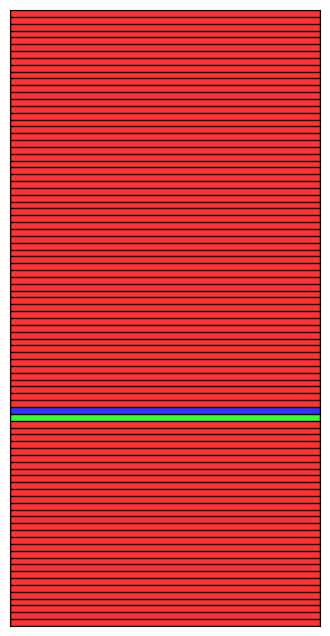

In [19]:
draw_1d_grid(id_array[number],nbars_array[number])

2


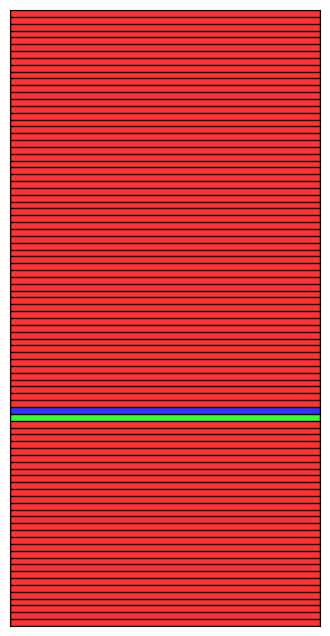

2


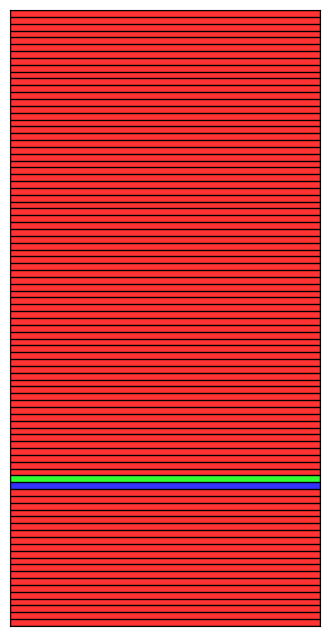

2


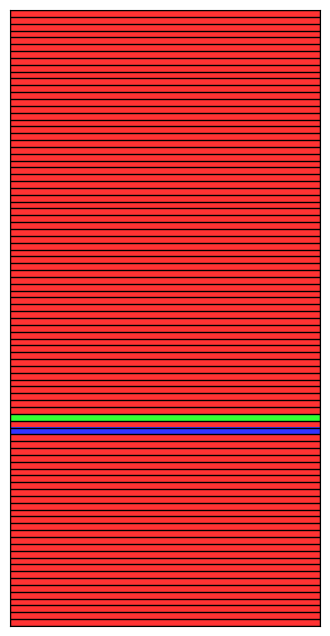

3


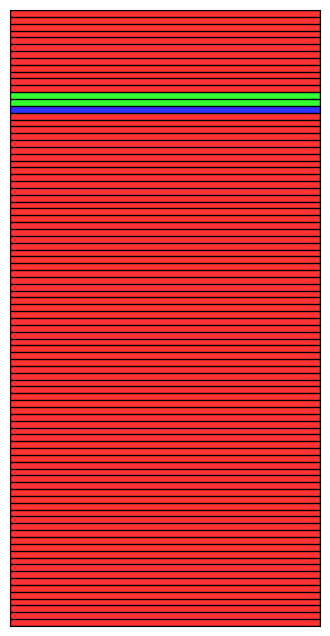

2


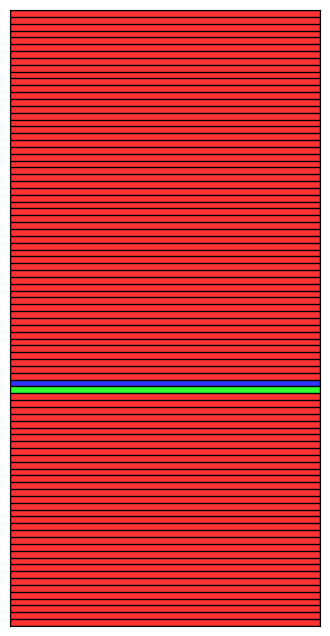

3


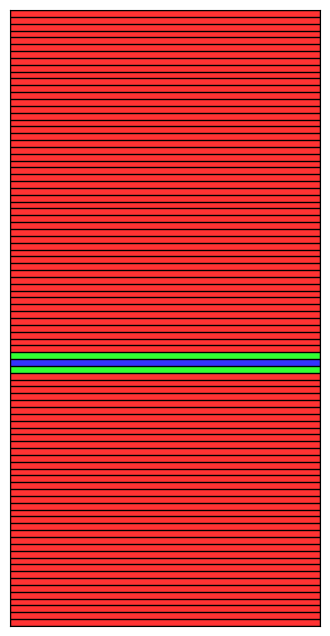

In [20]:
for i in range(0,len(eventCheck)):
    print(nbars_array[i])
    draw_1d_grid(id_array[i],nbars_array[i])


In [21]:
len(nbars_array)

802179

# PathFinding

### Define path

In [22]:
# Function to determine path from master block to any other block in 1D
def find_path_to_block_1d(master_block, target_block):
    current_block = master_block
    path = []
    
    # Traverse vertically (since it's a 1D detector, we only move up or down)
    while current_block != target_block:
        if current_block < target_block:
            next_block = current_block + 1  # Move down (increment block ID)
        else:
            next_block = current_block - 1  # Move up (decrement block ID)
        
        path.append(f"{current_block}to{next_block}")
        current_block = next_block

    return path

# Example usage:
master_block = 45  # Master block
target_block = 90  # Target block for the path calculation
path = find_path_to_block_1d(master_block, target_block)
print(f"Path from block {master_block} to block {target_block}: {path}")


Path from block 45 to block 90: ['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81', '81to82', '82to83', '83to84', '84to85', '85to86', '86to87', '87to88', '88to89', '89to90']


### Path Finding Visualization

Path from 45 to 46: ['45to46']


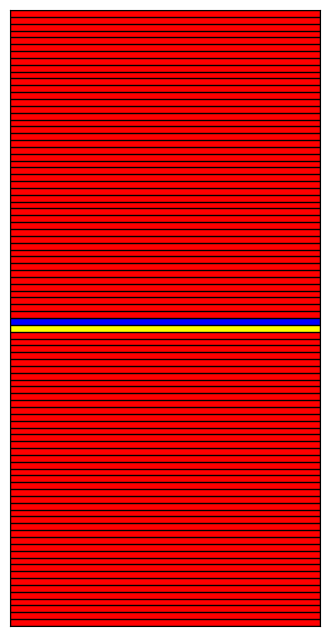

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to draw a 1D vertical detector with 90 bars and plot path from master block to target block
def draw_1d_grid_with_path(master_block, target_block, path):
    rows, cols = 90, 1  # 90 bars vertically, 1 column
    grid = np.zeros((rows, cols))
    
    # Mark the path on the grid
    for connection in path:
        start_block, end_block = map(int, connection.split('to'))
        grid[end_block, 0] = 1  # Mark path cells as green
        
    # Mark the master block and target block separately
    grid[master_block, 0] = 2  # Mark the master block as blue
    grid[target_block, 0] = 3  # Mark the target block as yellow
    
    # Create a colormap with transparency
    cmap = mcolors.ListedColormap(['red', 'green', 'blue', 'yellow'])  # Red: other, Green: path, Blue: master, Yellow: target
    
    # Plot the grid
    fig, ax = plt.subplots(figsize=(4, 8))  # Adjusted size for vertical display
    ax.imshow(grid, cmap=cmap, aspect='auto')
    
    # Draw the gridlines
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Show the plot
    plt.show()

# Example usage:
master_block = 45
target_block = 46
path = find_path_to_block_1d(master_block, target_block)  # Assume you already have the path function
print(f"Path from {master_block} to {target_block}: {path}")
draw_1d_grid_with_path(master_block, target_block, path)


### Path Finding Variables

In [24]:
import random

# Function to get adjacent blocks for a 1D vertical detector
def get_adjacent_blocks_1d(block_id, max_blocks=90):
    adjacent_blocks = []
    
    # Above neighbor
    if block_id > 0:  # Block 0 has no block above it
        adjacent_blocks.append(block_id - 1)
    
    # Below neighbor
    if block_id < max_blocks - 1:  # Last block has no block below it
        adjacent_blocks.append(block_id + 1)
    
    return adjacent_blocks

# Function to initialize path variables between adjacent blocks for 1D detector
def initialize_adjacent_path_variables_1d(max_blocks=90):
    path_values = {}  # Dictionary to store path variables and their values

    # Loop through all blocks in the 1D detector
    for block in range(max_blocks):  # Blocks from 0 to 89
        adjacent_blocks = get_adjacent_blocks_1d(block, max_blocks)  # Get adjacent blocks
        
        # Create path variables for each adjacent block
        for adj_block in adjacent_blocks:
            path_name = f"{block}to{adj_block}"
            reverse_path_name = f"{adj_block}to{block}"
            
            # Assign random values between 0 and 2
            path_values[path_name] = -1000
            path_values[reverse_path_name] = -1000

    return path_values

# Example usage:
path_variables = initialize_adjacent_path_variables_1d()




In [25]:
len(path_variables)

178

### Histogram Initialization

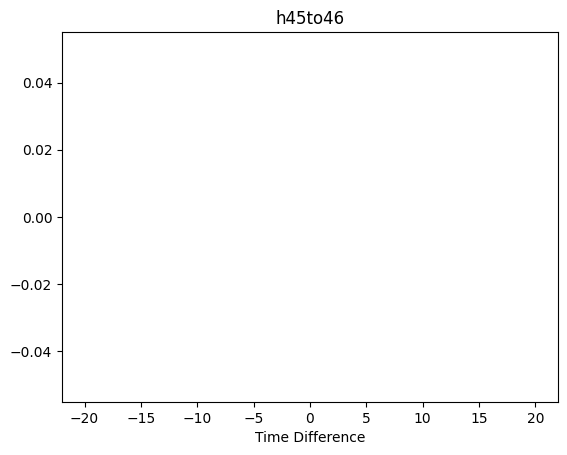

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Function to get adjacent blocks for a 1D vertical detector
def get_adjacent_blocks_1d(block_id, max_blocks=90):
    adjacent_blocks = []
    
    # Above neighbor
    if block_id > 0:  # Block 0 has no block above it
        adjacent_blocks.append(block_id - 1)
    
    # Below neighbor
    if block_id < max_blocks - 1:  # Last block has no block below it
        adjacent_blocks.append(block_id + 1)
    
    return adjacent_blocks

# Function to initialize empty histograms for adjacent paths for 1D detector
def initialize_adjacent_histograms_1d(max_blocks=90):
    histograms = {}  # Dictionary to store histograms
    
    # Loop through all blocks in the 1D detector
    for block in range(max_blocks):  # Blocks from 0 to 89
        adjacent_blocks = get_adjacent_blocks_1d(block, max_blocks)  # Get adjacent blocks
        
        # Create empty histograms for each adjacent block pair
        for adj_block in adjacent_blocks:
            hist_name = f"h{block}to{adj_block}"
            reverse_hist_name = f"h{adj_block}to{block}"
            
            # Initialize histograms as empty arrays
            histograms[hist_name] = np.array([])  # Empty array for histogram
            histograms[reverse_hist_name] = np.array([])  # Empty array for reverse path

    return histograms

# Function to plot a specific histogram by name
def plot_histogram(histograms, hist_name):
    if hist_name in histograms:
        plt.hist(histograms[hist_name], bins=150, range=(-20, 20), alpha=0.75, color='dodgerblue')
        plt.title(f"{hist_name}")
        plt.xlabel('Time Difference')
        
        plt.show()
    else:
        print(f"Histogram {hist_name} not found!")

# Example usage:
histograms = initialize_adjacent_histograms_1d()

# Example: Plot a specific histogram, e.g., for the path 45 to 46
plot_histogram(histograms, 'h45to46')


# Populate the histograms

(array([     0.,      0., 516057., 235529.,  50593.,      0.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

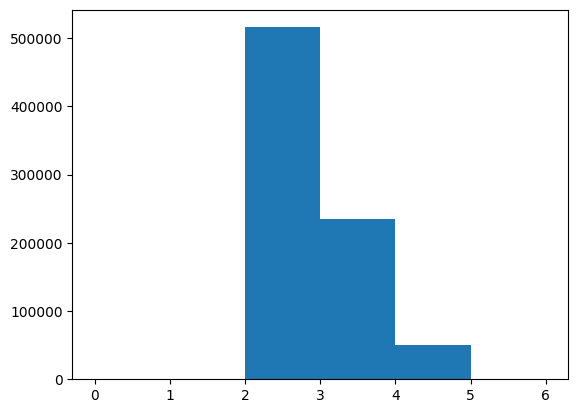

In [27]:
plt.hist(nbars_array,range=(0,6),bins=6)

Starting File 0
Starting File 1
Starting File 2
Starting File 3


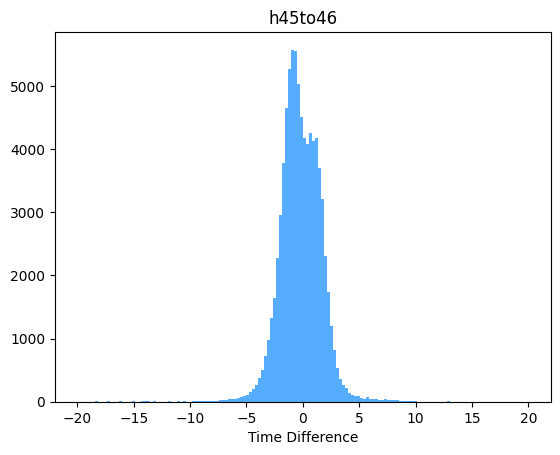

In [28]:
import numpy as np
def populate_histograms_multiple_events_1d(cblkid_2d, cblktime_2d, nbar_array, histograms):
    
    for k in range(0,4):
        print(f"Starting File {k}")
        dataToLoad=np.load(f"../outfiles/HodoArrays/hodo_data{k}.npz")
        id_array=dataToLoad["hodoID_array"].astype(int)
        time_array=dataToLoad["hodoTime_array"]
        nbars_array=dataToLoad["nbars_array"].astype(int)
        
        cblkid_2d=id_array
        cblktime_2d=time_array
        nbar_array=nbars_array
        
        num_events = len(cblkid_2d) 

        # Loop 
        for event_idx in range(num_events):
            cblkid = cblkid_2d[event_idx] # Bar IDs for this event
            cblktime = cblktime_2d[event_idx]  # Bar times for this event
            nbar = nbar_array[event_idx]  # Number of valid bars in this event

            

            # Populate histograms
            for i in range(nbar):
                for j in range(i + 1, nbar):  # Compare with the next bar in the list

                    
                    bar1 = cblkid[i]
                    bar2 = cblkid[j]

                    # Ensure bar1 and bar2 are adjacent
                    if abs(bar1 - bar2) == 1:  
                        
                        time_diff = cblktime[i] - cblktime[j]

                        
                        if abs(cblktime[i]) > 500 or abs(cblktime[j]) > 500:
                            continue

                        
                        if time_diff == 0:
                            print(f"Event {event_idx}, bar1 time: {cblktime[i]}, bar2 time: {cblktime[j]}")

                        
                        histograms[f"h{bar1}to{bar2}"] = np.append(histograms[f"h{bar1}to{bar2}"], time_diff)
                        histograms[f"h{bar2}to{bar1}"] = np.append(histograms[f"h{bar2}to{bar1}"], -time_diff)
    




histograms = initialize_adjacent_histograms_1d()  


populate_histograms_multiple_events_1d(id_array, time_array, nbars_array, histograms)


plot_histogram(histograms, 'h45to46')



# Fitting with double gaussian

Peak of the double Gaussian occurs at x = -0.98 with height = 5191.99


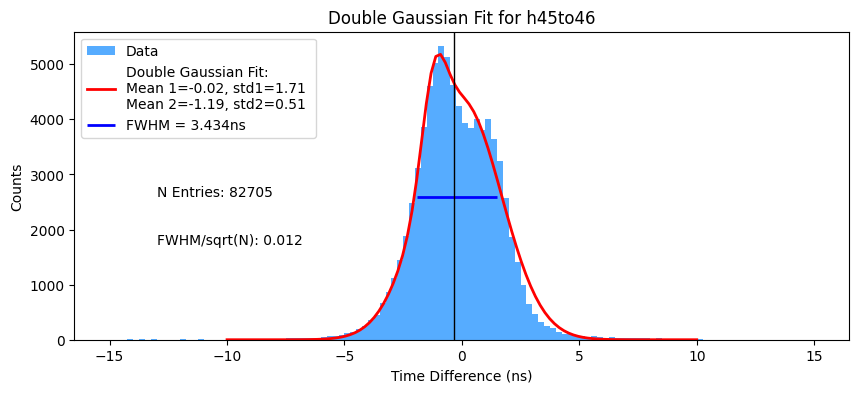

Combined Mean (mean1-2): -0.341
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 10191.631
(A1, A2): (18529.053599791987, 2076.541193414686)


(-0.9759759759759756,
 0.011942021244774713,
 -0.3412681622819357,
 0.005167266068799766,
 5095.81569907067)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# Double Gaussian function
def double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2):
    """Double Gaussian function: sum of two Gaussian curves."""
    return (A1 * norm.pdf(x, mu1, sigma1)) + (A2 * norm.pdf(x, mu2, sigma2))

def find_peak_of_double_gaussian(mu1, sigma1, A1, mu2, sigma2, A2):
    # Create a fine grid of x-values within the relevant range (adjust this range as needed)
    x = np.linspace(-15, 15, 1000)
    
    # Evaluate the double Gaussian function over this grid
    y = double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2)
    
    # Find the x-value where the function reaches its maximum
    peak_x = x[np.argmax(y)]
    peak_y = np.max(y)
    
    return peak_x, peak_y

def calculate_fwhm(x, y, peak_y):
    half_max = peak_y / 2  # Half of the maximum value
    # Find indices where the Gaussian curve crosses the half-max value
    indices = np.where(y >= half_max)[0]
    if len(indices) < 2:
        return None, None, None, None  # In case FWHM cannot be determined

    # The left and right boundaries for the FWHM
    left_idx = indices[0]
    right_idx = indices[-1]

    # The x-values corresponding to the FWHM
    left_fwhm = x[left_idx]
    right_fwhm = x[right_idx]

    fwhm_value = right_fwhm - left_fwhm
    
    return left_fwhm, right_fwhm, fwhm_value, half_max

# Function to plot a histogram and fit a double Gaussian function to it
def plot_histogram_with_double_gaussian(histograms, hist_name):
    if hist_name in histograms:
        datah = histograms[hist_name]
        plt.figure(figsize=(10, 4))
        # Filter the data to only include values in the range [-10, 10]
        data = datah[(datah >= -10) & (datah <= 10)]
        nEntries = len(data)
        # Plot the histogram of the original data with counts on the y-axis
        counts, bins, _ = plt.hist(datah, bins=120, alpha=0.75, color='dodgerblue', range=(-15, 15), label='Data')
        bin_width = bins[1] - bins[0]
        
        # Use bin centers for fitting
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Initial guesses for the parameters of the double Gaussian
        mu1_initial, sigma1_initial = norm.fit(data)
        mu2_initial, sigma2_initial = mu1_initial + 1, sigma1_initial
        A1_initial, A2_initial = max(counts) * bin_width, max(counts) * bin_width / 2  # Scale amplitudes to match the histogram
        
        initial_guess = [mu1_initial, sigma1_initial, A1_initial, mu2_initial, sigma2_initial, A2_initial]
        
        # Fit the double Gaussian to the data
        popt, _ = curve_fit(double_gaussian, bin_centers, counts, p0=initial_guess)
        mu1, sigma1, A1, mu2, sigma2, A2 = popt
        peak_x, peak_y = find_peak_of_double_gaussian(mu1, sigma1, A1, mu2, sigma2, A2)
        
        x = np.linspace(-10, 10, 100)
        # Generate the fitted double Gaussian curve
        p_double_gaussian = double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2)
        #fwhm addition
        left_fwhm, right_fwhm, fwhm_value, half_max = calculate_fwhm(x, p_double_gaussian, peak_y)
        print(f"Peak of the double Gaussian occurs at x = {peak_x:.2f} with height = {peak_y:.2f}")
        
        # PLOTTING
        plt.plot(x, p_double_gaussian, 'r', linewidth=2, label=f'Double Gaussian Fit: \nMean 1={mu1:.2f}, std1={sigma1:.2f} \nMean 2={mu2:.2f}, std2={sigma2:.2f}')
        
        if fwhm_value != None:
            plt.hlines(half_max, left_fwhm, right_fwhm, colors='blue', linestyles='-', lw=2, label=f"FWHM = {np.round(fwhm_value, 3)}ns")
        
        # Add labels and title
        plt.title(f"Double Gaussian Fit for {hist_name}")
        plt.xlabel('Time Difference (ns)')
        plt.ylabel("Counts")
        if fwhm_value != None:
            plt.text(-13, half_max, f"N Entries: {nEntries}")
            plt.text(-13, half_max / 1.5, f"FWHM/sqrt(N): {np.round(fwhm_value / np.sqrt(nEntries), 3)}")
            error = fwhm_value / np.sqrt(nEntries)
        else:
            error = 100
        plt.legend(loc='upper left')
        
        # MEAN1,2 and X^2-----------------------------------------
        
        # Step 1: Calculate the number of events under each Gaussian
        N1 = abs(A1) * np.sqrt(2 * np.pi) * sigma1  # Number of events under Gaussian 1
        N2 = abs(A2) * np.sqrt(2 * np.pi) * sigma2  # Number of events under Gaussian 2
        
        # Step 2: Calculate the accuracy as standard error
        accuracy1 = sigma1 / np.sqrt(N1)  # Standard error (accuracy) for Gaussian 1
        accuracy2 = sigma2 / np.sqrt(N2)  # Standard error (accuracy) for Gaussian 2
        
        # Step 3: Calculate the combined weighted mean (mean1-2)
        mean1_2 = (mu1 / accuracy1**2 + mu2 / accuracy2**2) / (1 / accuracy1**2 + 1 / accuracy2**2)
        
        # Step 4: Calculate the uncertainty in the combined mean
        sigma_mean1_2 = 1 / np.sqrt(1 / accuracy1**2 + 1 / accuracy2**2)
        
        # Step 5: Chi-squared calculation for the combined mean
        chi_squared = ((mu1 - mean1_2)**2 / accuracy1**2) + ((mu2 - mean1_2)**2 / accuracy2**2)
        
        # Plot the combined mean on the graph
        if A1 > 0 and A2 > 0:
            plt.axvline(mean1_2, color='black', lw=1, label=f"Mean1-2: {np.round(mean1_2, 3)}ns ± {np.round(sigma_mean1_2, 3)}")
        else:
            plt.axvline(peak_x, color='black', lw=1, label=f"Mean1-2: {np.round(peak_x, 3)}ns ± {np.round(error, 3)}")
        
        plt.show()

        # Print out the combined mean and chi-squared
        print(f"Combined Mean (mean1-2): {mean1_2:.3f}")
        print(f"Uncertainty in Combined Mean: {sigma_mean1_2:.3f}")
        print(f"Chi-Squared/DOF: {chi_squared:.3f}")
        print(f"(A1, A2): ({A1}, {A2})")
        
        # Optionally, you could return these values if you need to use them later
        if A1 > 0 and A2 > 0:
            return peak_x, error, mean1_2, sigma_mean1_2, chi_squared / 2
        else:
            return peak_x, error, peak_x, error, chi_squared / 2
        # ---------------------------------------------------------
        
    else:
        print(f"Histogram {hist_name} not found!")

# Example usage:
plot_histogram_with_double_gaussian(histograms, 'h45to46')


# $X ^2$ Minimization

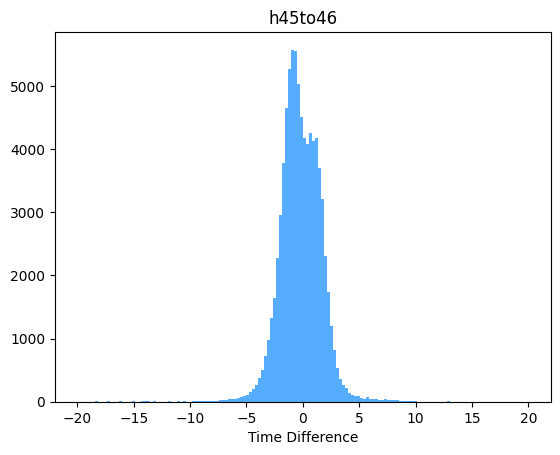

In [30]:
plot_histogram(histograms, 'h45to46')


# Pathfinding Histograms

In [31]:
#BadPaths

['0to1', '1to2', '2to3', '3to4', '4to5', '5to6', '6to7', '7to8', '8to9', '9to10', '10to11', '11to12', '12to13', '13to14', '14to15', '15to16', '16to17', '17to18', '18to19', '19to20', '20to21', '21to22', '22to23', '23to24', '24to25', '25to26', '26to27', '27to28', '28to29', '29to30', '30to31', '31to32', '32to33', '33to34', '34to35', '35to36', '36to37', '37to38', '38to39', '39to40', '40to41', '41to42', '42to43', '43to44', '44to45', '45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81', '81to82', '82to83', '83to84', '84to85', '85to86', '86to87', '87to88', '88to89']


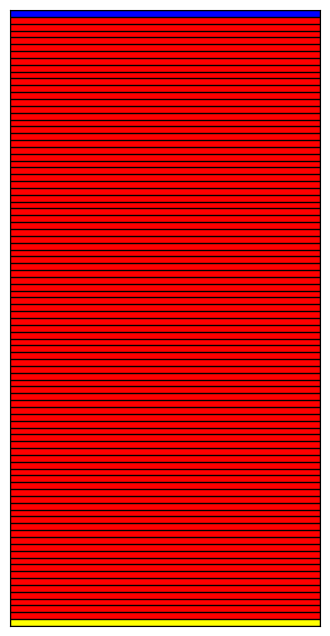

In [32]:
master_block = 0
target_block = 89
path = find_path_to_block_1d(master_block, target_block)  # Assume you already have the path function
print(path)
draw_1d_grid_with_path(master_block, target_block, path)
histogramPath= ['h' + p for p in path]

# Make Pdf of all histograms in above defined path

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import norm
from scipy.optimize import curve_fit

# Double Gaussian function
def double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2):
    """Double Gaussian function: sum of two Gaussian curves."""
    return (A1 * norm.pdf(x, mu1, sigma1)) + (A2 * norm.pdf(x, mu2, sigma2))

# Function to find the peak of the double Gaussian
def find_peak_of_double_gaussian(mu1, sigma1, A1, mu2, sigma2, A2):
    # Create a fine grid of x-values within the relevant range (adjust this range as needed)
    x = np.linspace(-15, 15, 1000)
    
    # Evaluate the double Gaussian function over this grid
    y = double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2)
    
    # Find the x-value where the function reaches its maximum
    peak_x = x[np.argmax(y)]
    peak_y = np.max(y)
    
    return peak_x, peak_y

# Function to plot a histogram and fit a double Gaussian function to it
def plot_histogram_with_double_gaussianPDF(histograms, hist_name):
    if hist_name in histograms:
        datah = histograms[hist_name]
        fig, ax = plt.subplots(figsize=(10, 4))  # Create a figure and axis
        
        # Filter the data to only include values in the range [-10, 10]
        data = datah[(datah >= -10) & (datah <= 10)]
        nEntries=len(data)
        # Plot the histogram of the original data with counts on the y-axis
        counts, bins, _ = plt.hist(datah, bins=120, alpha=0.75, color='dodgerblue', range=(-15, 15), label='Data')
        bin_width = bins[1] - bins[0]
        
        # Use bin centers for fitting
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Initial guesses for the parameters of the double Gaussian
        mu1_initial, sigma1_initial = norm.fit(data)
        mu2_initial, sigma2_initial = mu1_initial + 1, sigma1_initial
        A1_initial, A2_initial = max(counts) * bin_width, max(counts) * bin_width / 2  # Scale amplitudes to match the histogram
        
        initial_guess = [mu1_initial, sigma1_initial, A1_initial, mu2_initial, sigma2_initial, A2_initial]
        
        # Fit the double Gaussian to the data
        popt, _ = curve_fit(double_gaussian, bin_centers, counts, p0=initial_guess)
        mu1, sigma1, A1, mu2, sigma2, A2 = popt
        peak_x, peak_y = find_peak_of_double_gaussian(mu1, sigma1, A1, mu2, sigma2, A2)
        
        x = np.linspace(-10, 10, 100)
        # Generate the fitted double Gaussian curve
        p_double_gaussian = double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2)
        #fwhmaddition
        left_fwhm, right_fwhm, fwhm_value,half_max = calculate_fwhm(x, p_double_gaussian, peak_y)
        #print(f"Peak of the double Gaussian occurs at x = {peak_x:.2f} with height = {peak_y:.2f}")
        
        
        
        # Plot the fitted double Gaussian curve
        ax.plot(x, p_double_gaussian, 'r', linewidth=2, label=f'Double Gaussian Fit: \nMean 1={mu1:.2f}, std1={sigma1:.2f} \nMean 2={mu2:.2f}, std2={sigma2:.2f}')
        if fwhm_value!=None:
            ax.hlines(half_max, left_fwhm, right_fwhm, colors='blue', linestyles='-', lw=2, label=f"FWHM = {np.round(fwhm_value, 3)}ns")
        # Add labels and title
        ax.set_title(f"Double Gaussian Fit for {hist_name}")
        ax.set_xlabel('Time Difference (ns)')
        ax.set_ylabel("Counts")
        ax.axvline(peak_x,color='black',lw=1,label=f"Peak: {np.round(peak_x,3)}ns")
        if fwhm_value!=None:
            ax.text(-13,half_max,f"N Entries: {nEntries}")
        
            ax.text(-13,half_max/1.5,f"FWHM/sqrt(nEntries): {np.round(fwhm_value/np.sqrt(nEntries),3)}")
            error=fwhm_value/np.sqrt(nEntries)
        else:
            error=100
        ax.legend(loc='upper left')
        # Plot the fitted double Gaussian curve
        #ax.plot(x, p_double_gaussian, 'r', linewidth=2, label=f'Double Gaussian Fit: \nmean1={mu1:.2f}, std1={sigma1:.2f} \nmean2={mu2:.2f}, std2={sigma2:.2f}')
        
        # Add labels and title
        #ax.set_title(f"Double Gaussian Fit for {hist_name}")
        #ax.set_xlabel('Time Difference (ns)')
       #ax.set_ylabel("Counts")
       # ax.axvline(peak_x, color='black', lw=1, label=f"Peak: {np.round(peak_x, 3)}ns")

        #ax.legend(loc='upper left')
        
        return fig  # Return the figure object instead of showing the plot
    else:
        print(f"Histogram {hist_name} not found!")

# Example usage: Generating and saving 90 plots into a PDF
with PdfPages('double_gaussian_plots.pdf') as pdf:
    for i in range(0,89):  # Assuming you have 90 histograms
        hist_name = histogramPath[i]
        fig = plot_histogram_with_double_gaussianPDF(histograms, hist_name)  # Generate each plot
        pdf.savefig(fig)  # Save the current figure into the PDF
        plt.close(fig)  # Close the figure to free up memory

print("PDF with 90 plots saved as 'double_gaussian_plots.pdf'")


/home/research/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:409: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/research/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:414: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


PDF with 90 plots saved as 'double_gaussian_plots.pdf'


Peak of the double Gaussian occurs at x = 1.13 with height = 209.22


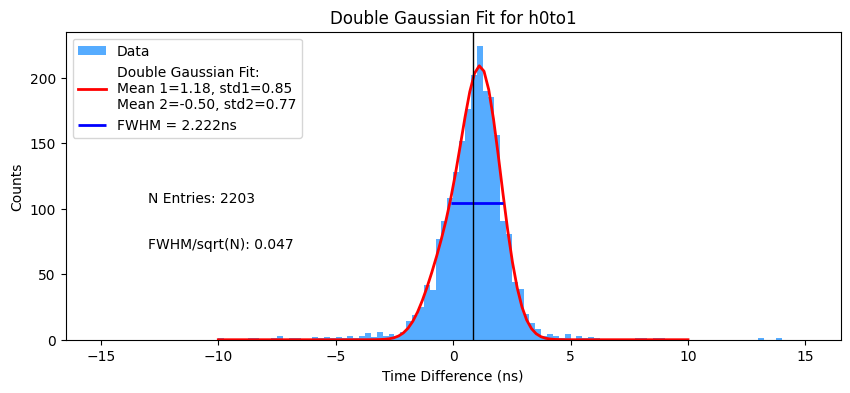

Combined Mean (mean1-2): 0.864
Uncertainty in Combined Mean: 0.025
Chi-Squared/DOF: 682.430
(A1, A2): (437.91303500569165, 91.3591278130825)
Peak of the double Gaussian occurs at x = 0.77 with height = 15.11


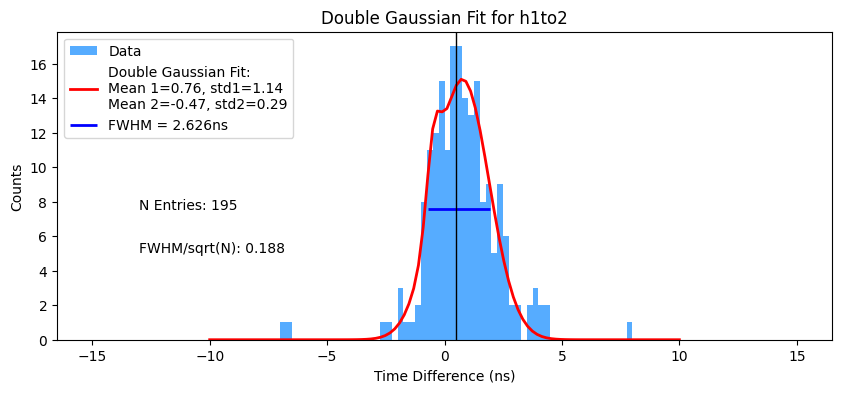

Combined Mean (mean1-2): 0.499
Uncertainty in Combined Mean: 0.091
Chi-Squared/DOF: 30.332
(A1, A2): (43.2293490210926, 2.9699685298298526)
Peak of the double Gaussian occurs at x = -2.90 with height = 28.17


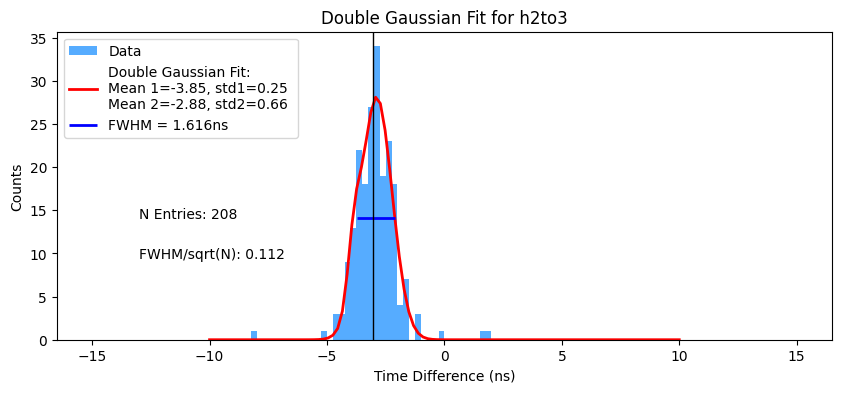

Combined Mean (mean1-2): -3.051
Uncertainty in Combined Mean: 0.068
Chi-Squared/DOF: 28.547
(A1, A2): (3.7379782484276305, 46.486016939377684)
Peak of the double Gaussian occurs at x = 3.74 with height = 241.28


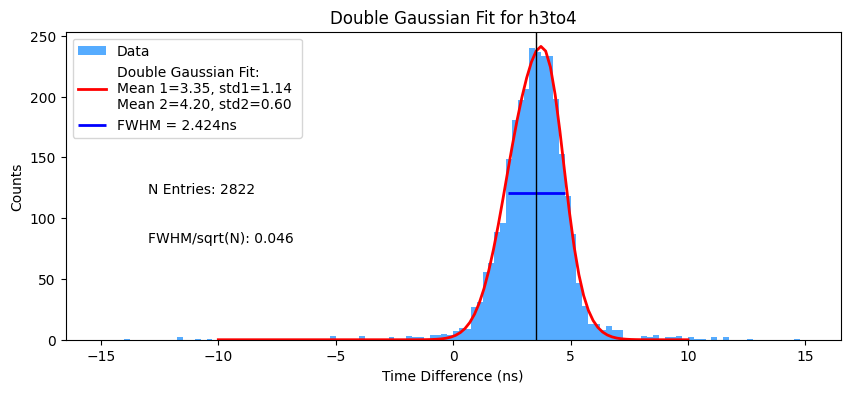

Combined Mean (mean1-2): 3.545
Uncertainty in Combined Mean: 0.024
Chi-Squared/DOF: 216.765
(A1, A2): (589.8716974123287, 93.73964181410747)
Peak of the double Gaussian occurs at x = -1.79 with height = 832.39


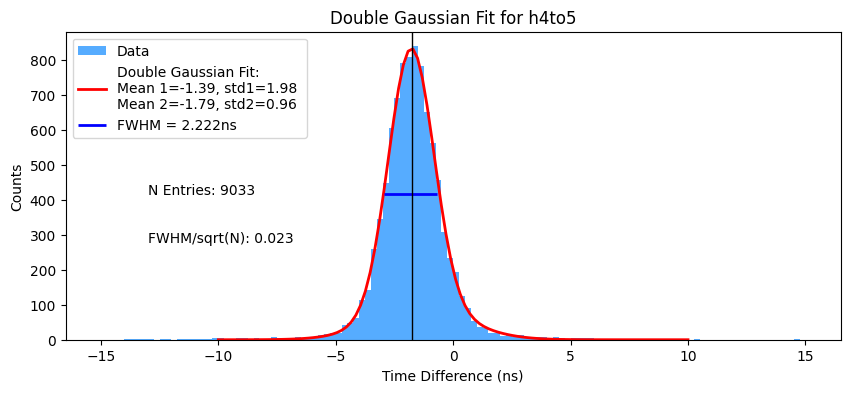

Combined Mean (mean1-2): -1.748
Uncertainty in Combined Mean: 0.014
Chi-Squared/DOF: 76.951
(A1, A2): (423.98057303978254, 1806.5807962187694)
Peak of the double Gaussian occurs at x = 1.10 with height = 171.68


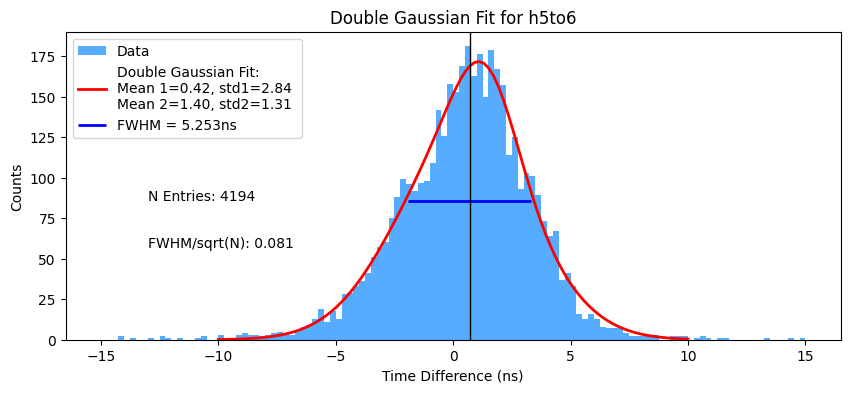

Combined Mean (mean1-2): 0.722
Uncertainty in Combined Mean: 0.030
Chi-Squared/DOF: 223.632
(A1, A2): (872.0385694466776, 177.0052838837565)
Peak of the double Gaussian occurs at x = -2.06 with height = 178.66


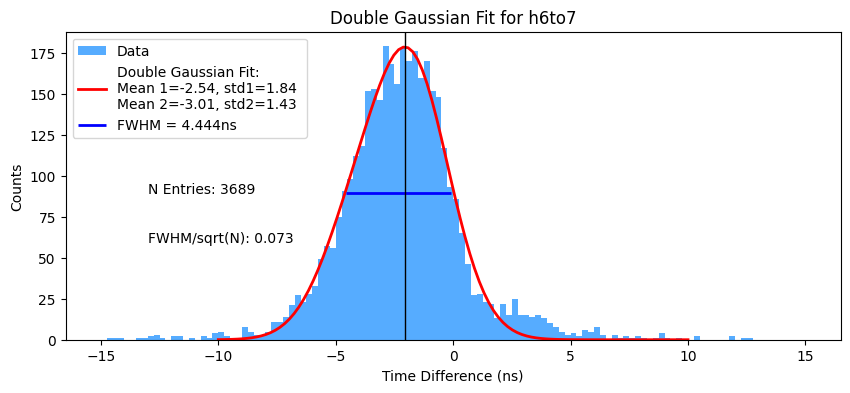

Combined Mean (mean1-2): -2.669
Uncertainty in Combined Mean: 0.021
Chi-Squared/DOF: 98.799
(A1, A2): (1226.0411589124874, -348.7505796449986)
Peak of the double Gaussian occurs at x = 0.83 with height = 14082.47


/home/research/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


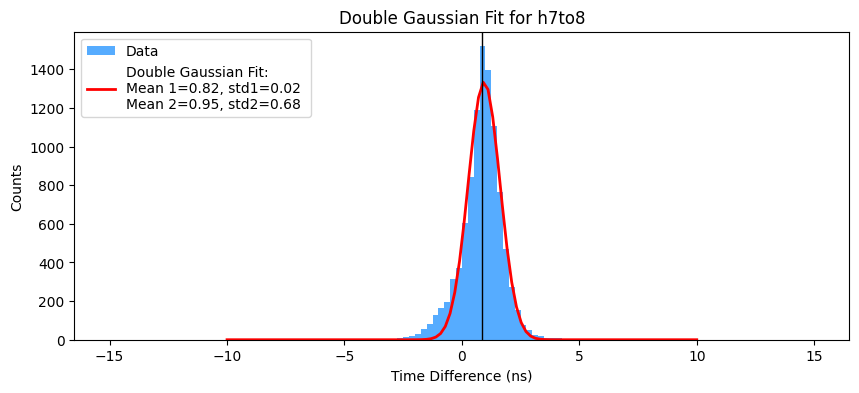

Combined Mean (mean1-2): 0.836
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 110.910
(A1, A2): (555.0823107795053, 2270.9608188172583)
Peak of the double Gaussian occurs at x = 0.56 with height = 31.02


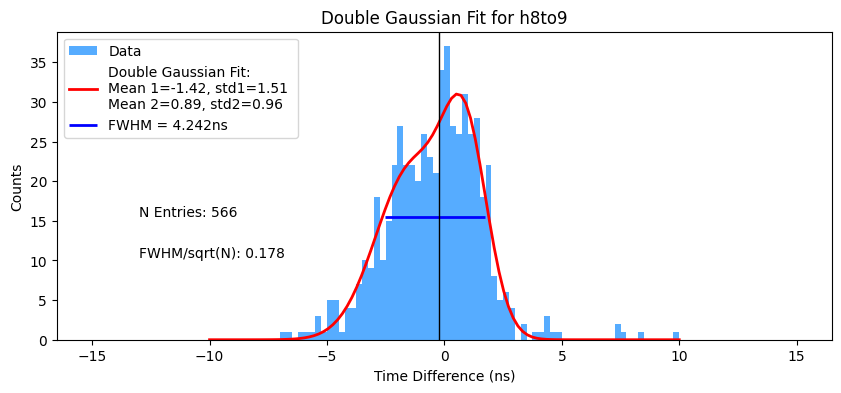

Combined Mean (mean1-2): -0.214
Uncertainty in Combined Mean: 0.060
Chi-Squared/DOF: 374.808
(A1, A2): (81.11865181525522, 55.822323619117)
Peak of the double Gaussian occurs at x = -0.53 with height = 61.87


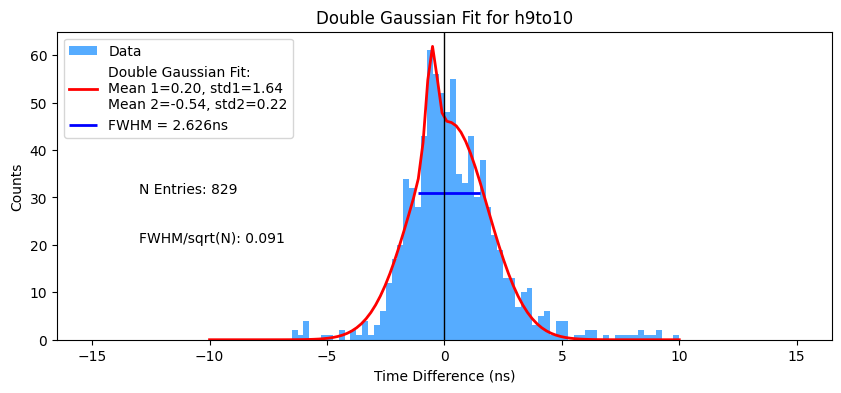

Combined Mean (mean1-2): -0.026
Uncertainty in Combined Mean: 0.049
Chi-Squared/DOF: 49.433
(A1, A2): (188.11869054864144, 11.316720443166474)
Peak of the double Gaussian occurs at x = 0.32 with height = 2882.59


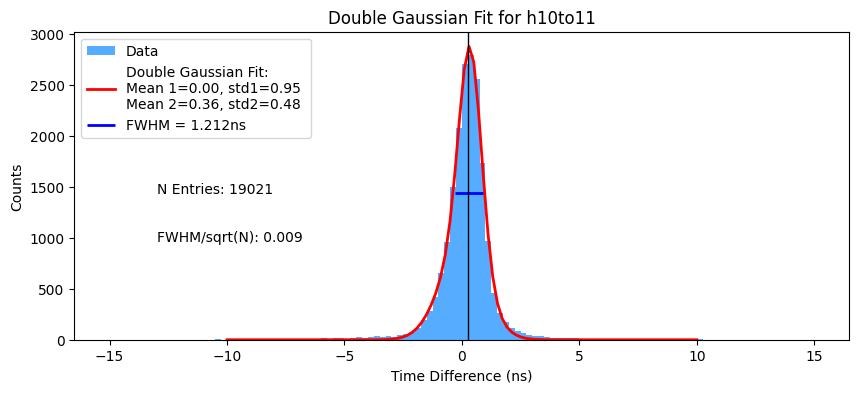

Combined Mean (mean1-2): 0.252
Uncertainty in Combined Mean: 0.007
Chi-Squared/DOF: 483.816
(A1, A2): (2089.4614427287665, 2467.916024947691)
Peak of the double Gaussian occurs at x = -0.95 with height = 2920.13


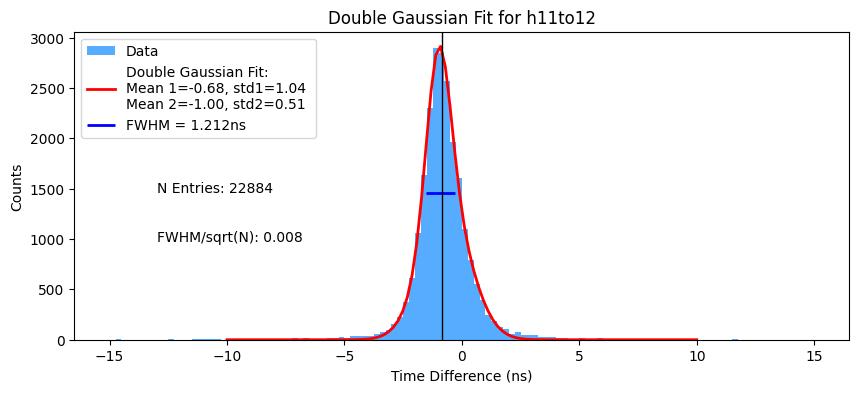

Combined Mean (mean1-2): -0.863
Uncertainty in Combined Mean: 0.007
Chi-Squared/DOF: 481.175
(A1, A2): (3307.706421925439, 2184.4798531844685)
Peak of the double Gaussian occurs at x = -0.20 with height = 3833.94


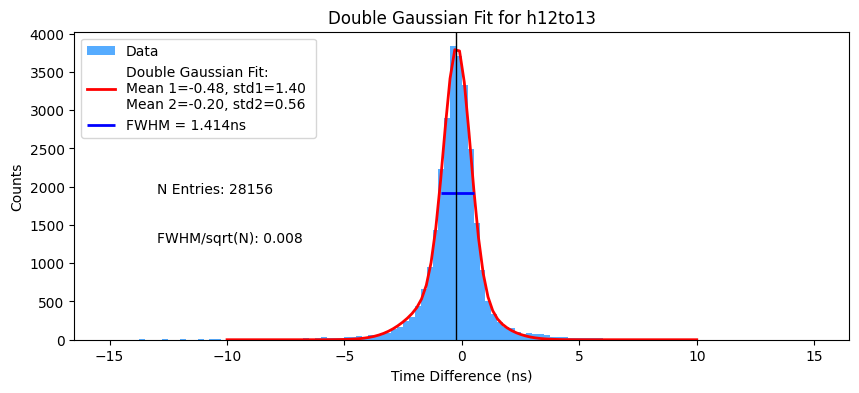

Combined Mean (mean1-2): -0.248
Uncertainty in Combined Mean: 0.006
Chi-Squared/DOF: 263.457
(A1, A2): (2331.913343415768, 4490.863614406117)
Peak of the double Gaussian occurs at x = 0.26 with height = 5395.17


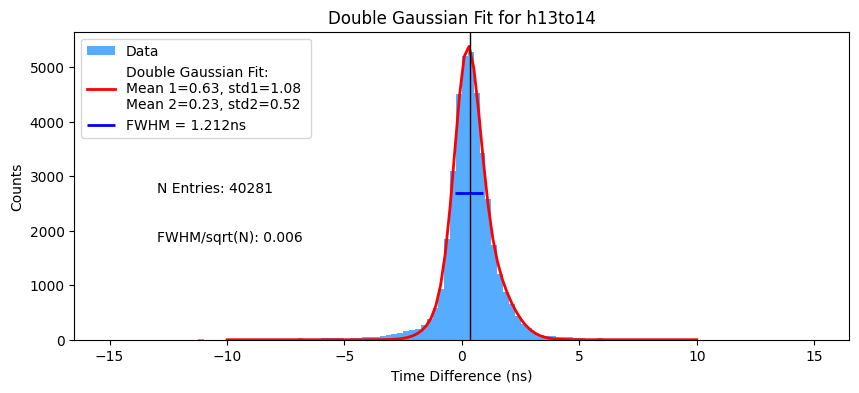

Combined Mean (mean1-2): 0.353
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 1207.493
(A1, A2): (4721.516473086695, 4936.789323876765)
Peak of the double Gaussian occurs at x = -0.02 with height = 7045.85


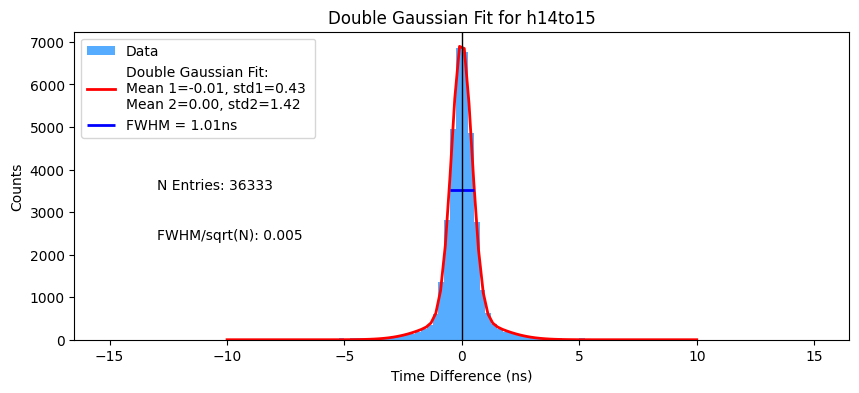

Combined Mean (mean1-2): -0.006
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 0.401
(A1, A2): (7085.055646661625, 1796.74450417245)
Peak of the double Gaussian occurs at x = -0.32 with height = 2133.51


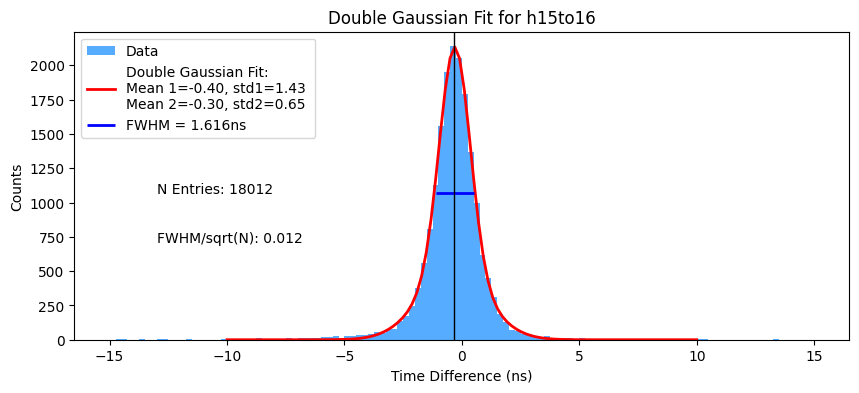

Combined Mean (mean1-2): -0.320
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 23.098
(A1, A2): (1686.6964783541473, 2717.6165623762568)
Peak of the double Gaussian occurs at x = -0.26 with height = 1806.04


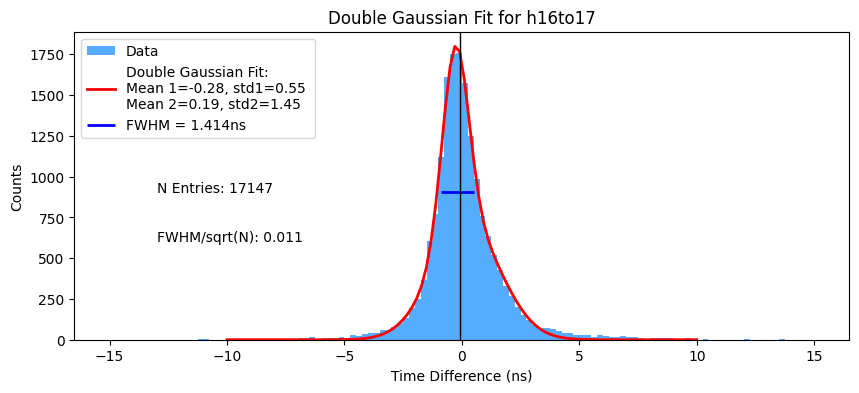

Combined Mean (mean1-2): -0.101
Uncertainty in Combined Mean: 0.009
Chi-Squared/DOF: 595.761
(A1, A2): (1582.3502161005908, 2529.7606519038245)
Peak of the double Gaussian occurs at x = -0.44 with height = 5241.02


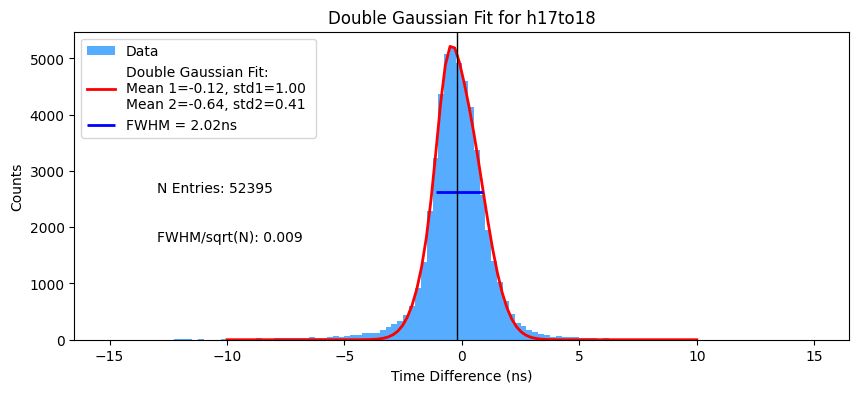

Combined Mean (mean1-2): -0.227
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 1556.570
(A1, A2): (11183.20574430055, 1182.176142860523)
Peak of the double Gaussian occurs at x = -0.08 with height = 4003.70


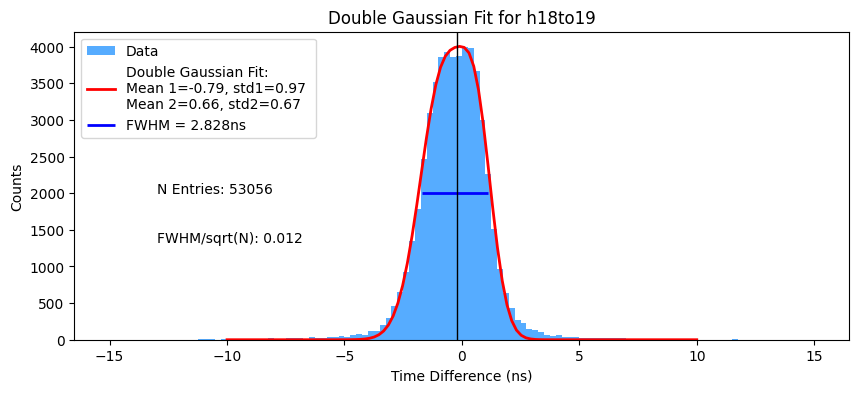

Combined Mean (mean1-2): -0.222
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 18826.935
(A1, A2): (8762.370635195104, 3909.1865126280886)
Peak of the double Gaussian occurs at x = -0.29 with height = 3110.39


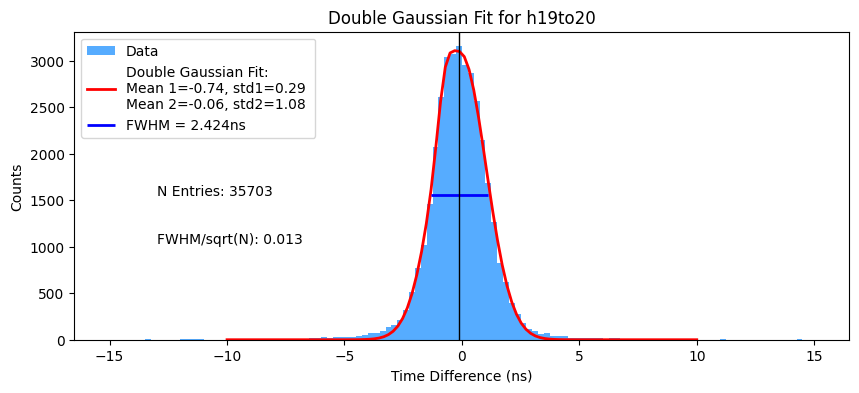

Combined Mean (mean1-2): -0.130
Uncertainty in Combined Mean: 0.007
Chi-Squared/DOF: 962.943
(A1, A2): (264.57146855102314, 8340.119232238198)
Peak of the double Gaussian occurs at x = 0.35 with height = 4537.81


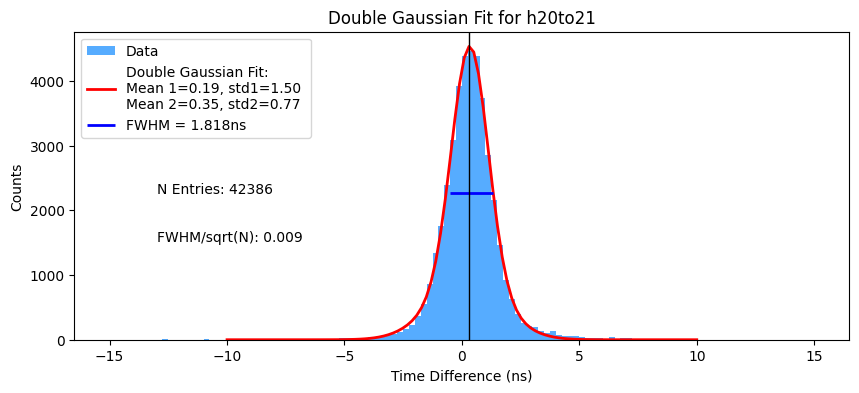

Combined Mean (mean1-2): 0.316
Uncertainty in Combined Mean: 0.006
Chi-Squared/DOF: 106.235
(A1, A2): (3346.614095109023, 7048.076623785397)
Peak of the double Gaussian occurs at x = 0.26 with height = 7390.23


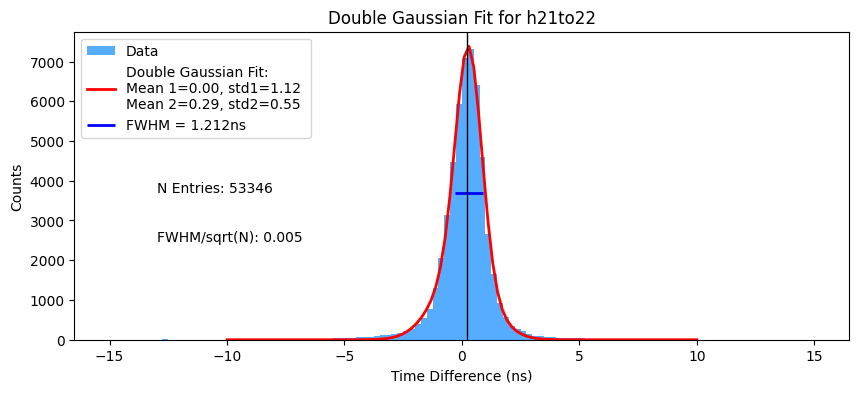

Combined Mean (mean1-2): 0.220
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 702.740
(A1, A2): (5067.748919125774, 7829.7494240624455)
Peak of the double Gaussian occurs at x = 0.08 with height = 7736.02


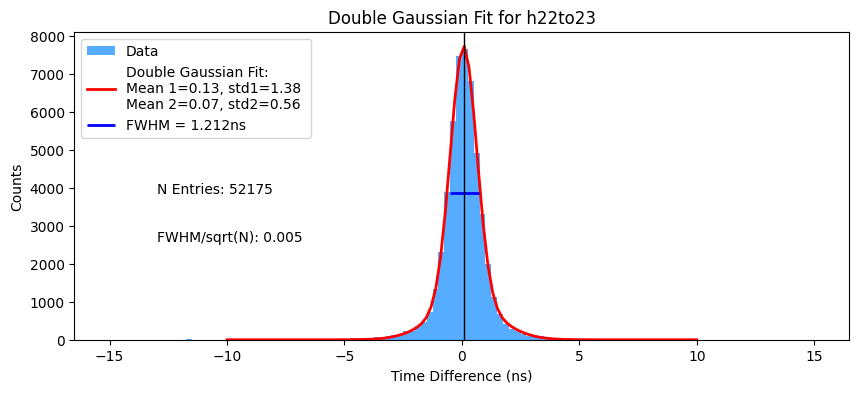

Combined Mean (mean1-2): 0.080
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 19.070
(A1, A2): (3282.1809935052192, 9512.106305851654)
Peak of the double Gaussian occurs at x = -0.05 with height = 10880.74


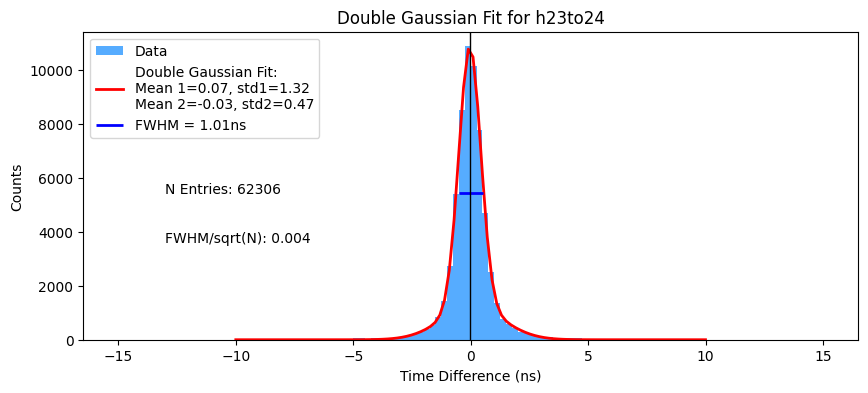

Combined Mean (mean1-2): -0.023
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 70.035
(A1, A2): (3915.540158934721, 11364.959102631481)
Peak of the double Gaussian occurs at x = -0.20 with height = 9871.74


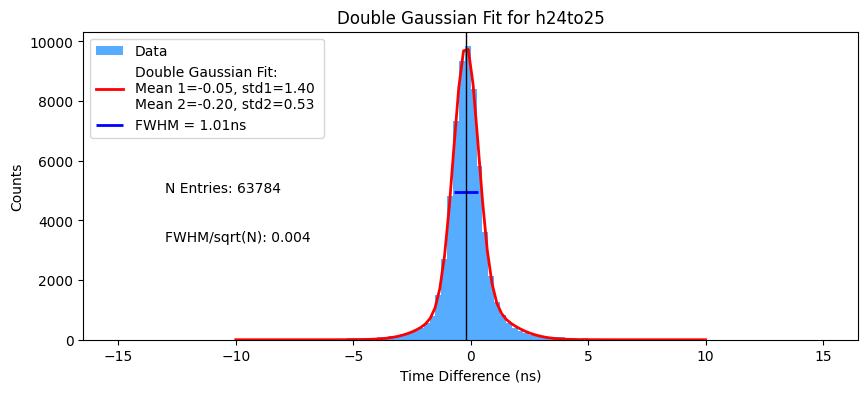

Combined Mean (mean1-2): -0.180
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 137.744
(A1, A2): (4194.088097778773, 11443.954836583145)
Peak of the double Gaussian occurs at x = -0.08 with height = 8860.78


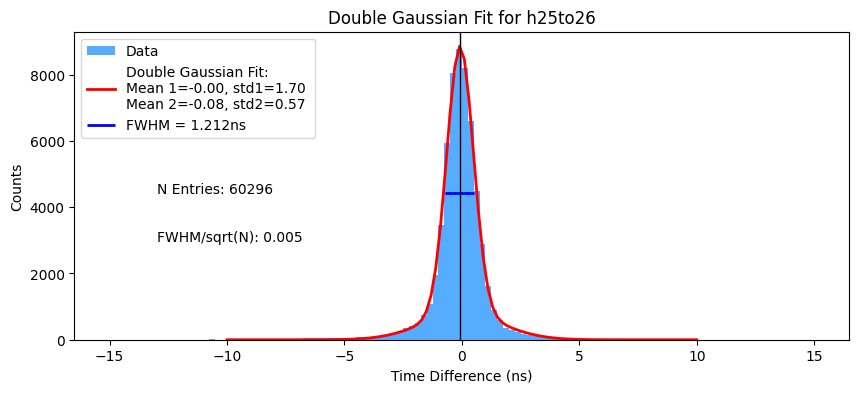

Combined Mean (mean1-2): -0.070
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 23.259
(A1, A2): (3291.2982691957, 11540.28100101501)
Peak of the double Gaussian occurs at x = -0.17 with height = 9799.88


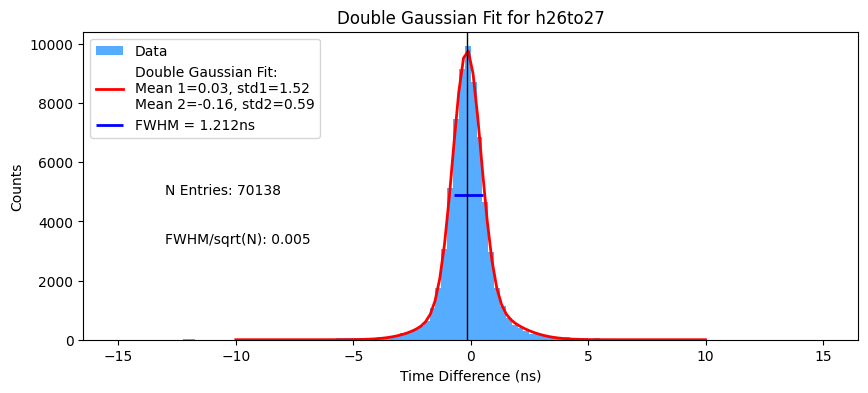

Combined Mean (mean1-2): -0.138
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 219.621
(A1, A2): (4364.46520958016, 12859.108899061312)
Peak of the double Gaussian occurs at x = -0.02 with height = 7218.95


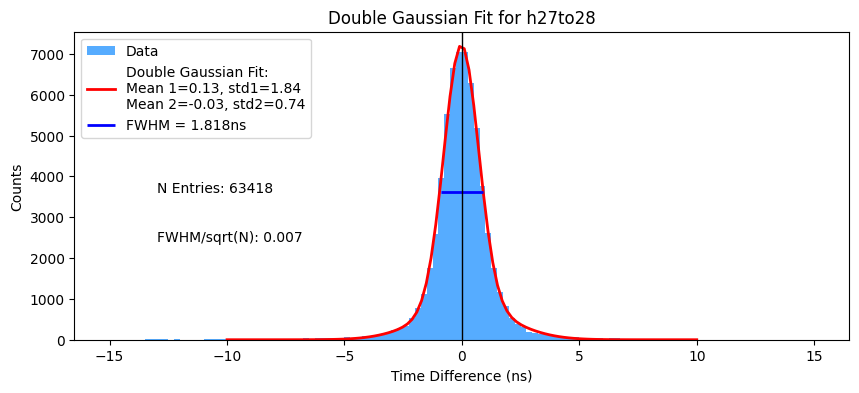

Combined Mean (mean1-2): -0.009
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 111.056
(A1, A2): (3750.3881319967754, 11859.780859827359)
Peak of the double Gaussian occurs at x = 0.02 with height = 7433.23


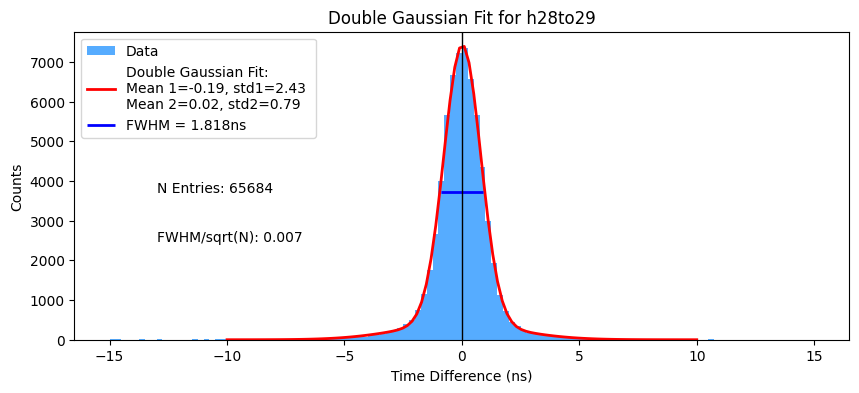

Combined Mean (mean1-2): 0.008
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 105.748
(A1, A2): (2440.0661713880404, 13882.369531741217)
Peak of the double Gaussian occurs at x = -0.17 with height = 4139.18


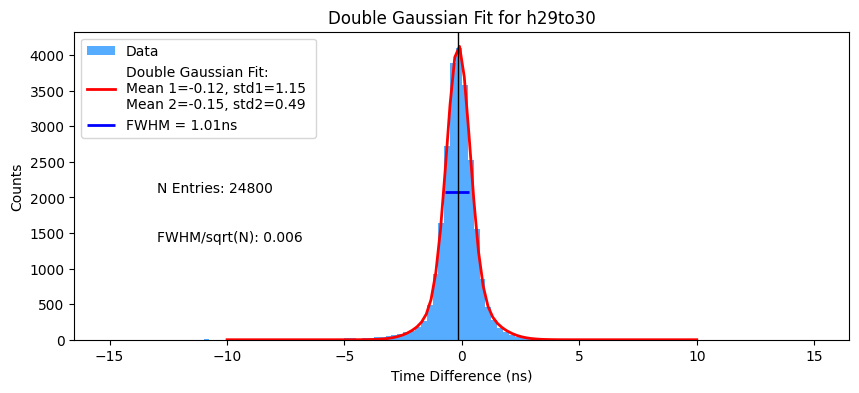

Combined Mean (mean1-2): -0.146
Uncertainty in Combined Mean: 0.006
Chi-Squared/DOF: 3.948
(A1, A2): (1715.4845035626618, 4377.135969573351)
Peak of the double Gaussian occurs at x = 0.65 with height = 2914.85


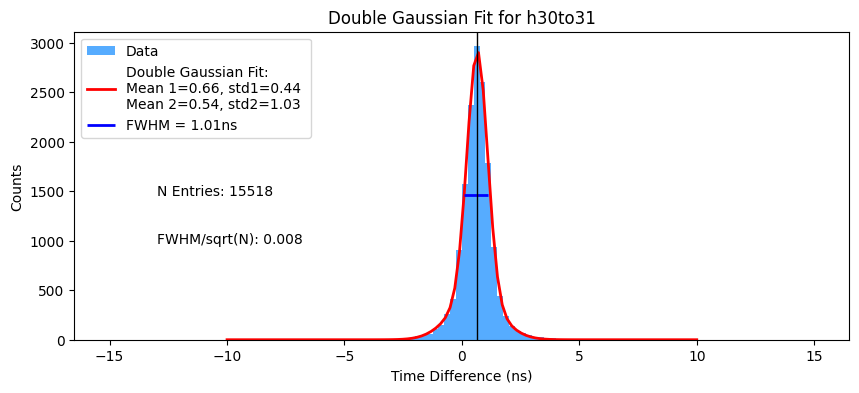

Combined Mean (mean1-2): 0.642
Uncertainty in Combined Mean: 0.007
Chi-Squared/DOF: 30.403
(A1, A2): (2716.712995114545, 1102.7382803168343)
Peak of the double Gaussian occurs at x = 0.53 with height = 9377.89


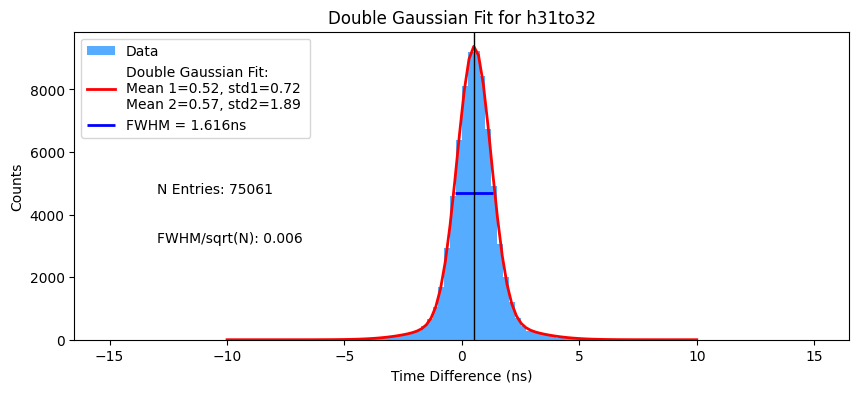

Combined Mean (mean1-2): 0.525
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 7.505
(A1, A2): (15815.145194312981, 2783.592549189571)
Peak of the double Gaussian occurs at x = 0.14 with height = 8379.73


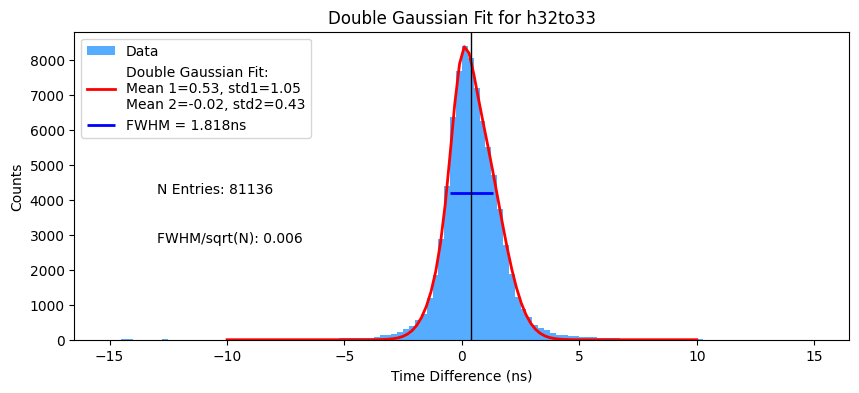

Combined Mean (mean1-2): 0.370
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 3587.795
(A1, A2): (16623.937948288734, 2891.2765431018347)
Peak of the double Gaussian occurs at x = 0.62 with height = 8315.13


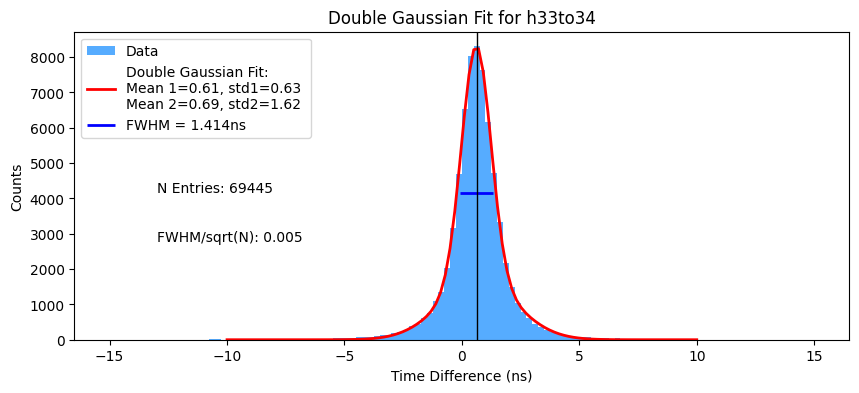

Combined Mean (mean1-2): 0.626
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 53.009
(A1, A2): (10519.45906217174, 6521.578451675336)
Peak of the double Gaussian occurs at x = 0.71 with height = 13290.43


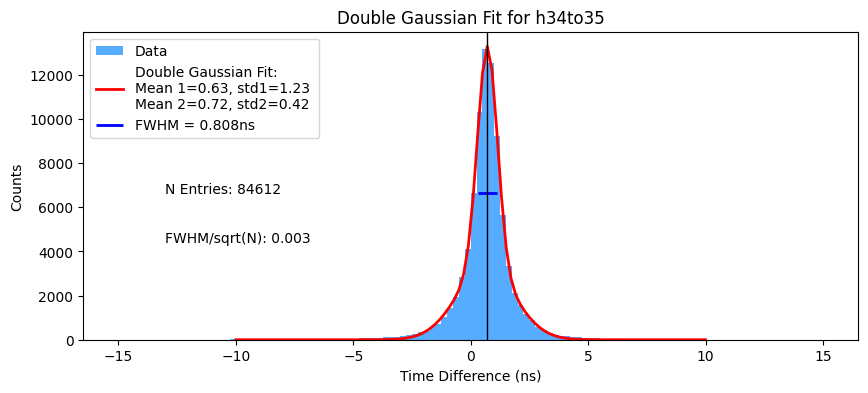

Combined Mean (mean1-2): 0.697
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 105.393
(A1, A2): (9920.335549566542, 10644.484881187025)
Peak of the double Gaussian occurs at x = 0.17 with height = 11786.96


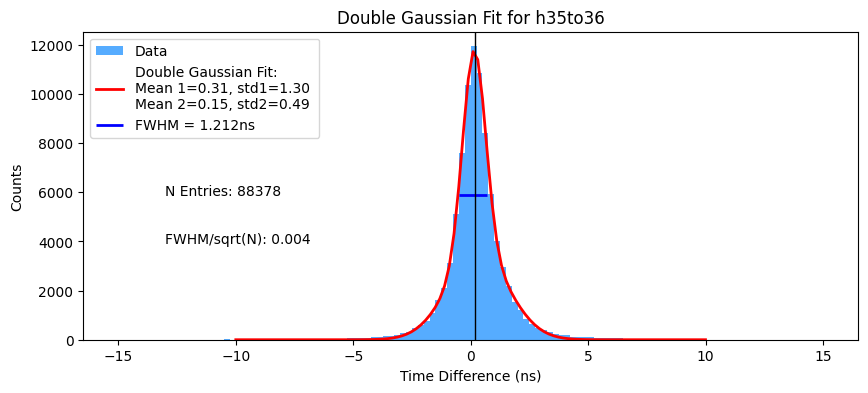

Combined Mean (mean1-2): 0.195
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 390.924
(A1, A2): (11174.316318572644, 10253.589116516823)
Peak of the double Gaussian occurs at x = 0.02 with height = 11659.87


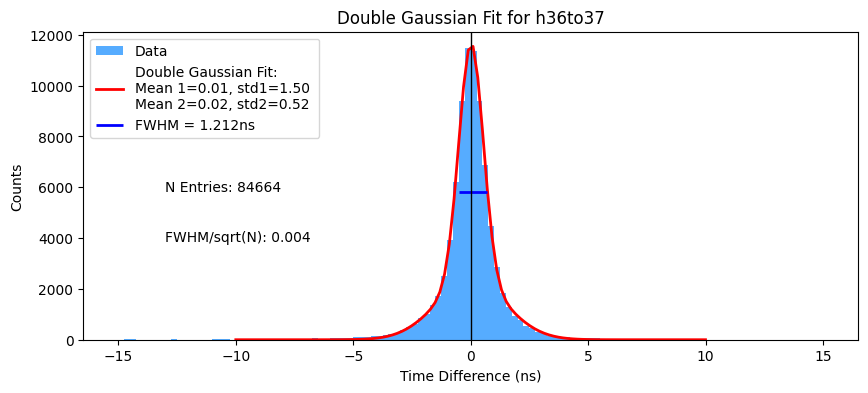

Combined Mean (mean1-2): 0.018
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 1.992
(A1, A2): (8452.753092401537, 12244.401314111175)
Peak of the double Gaussian occurs at x = -0.11 with height = 11421.03


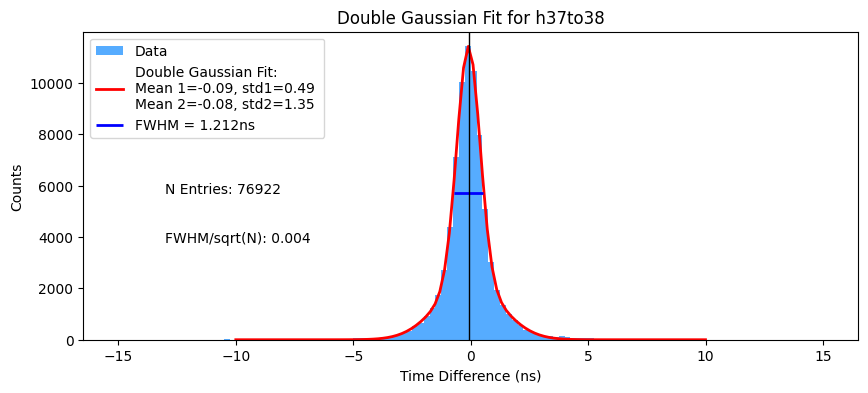

Combined Mean (mean1-2): -0.090
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 2.195
(A1, A2): (11352.580779924554, 7470.110828220946)
Peak of the double Gaussian occurs at x = -0.05 with height = 9918.65


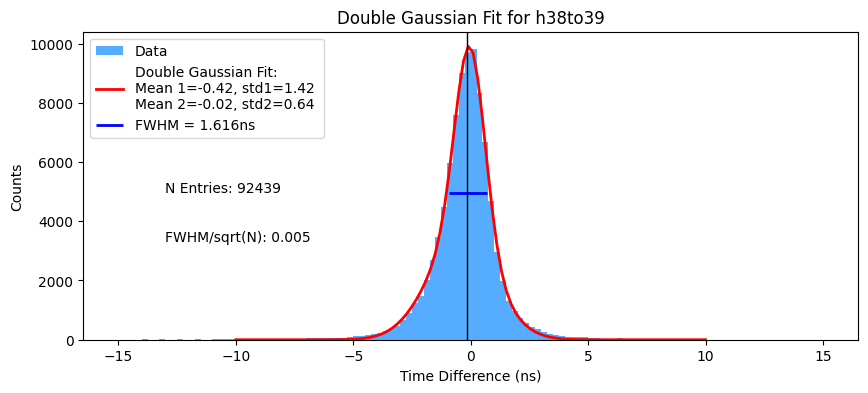

Combined Mean (mean1-2): -0.154
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 2216.077
(A1, A2): (11641.703476567705, 10857.626815564696)
Peak of the double Gaussian occurs at x = 0.08 with height = 9595.35


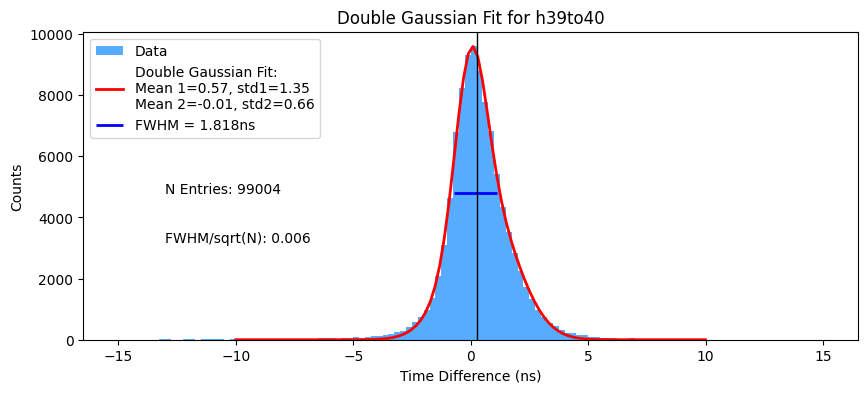

Combined Mean (mean1-2): 0.250
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 5060.225
(A1, A2): (15014.198626362953, 9031.05085145478)
Peak of the double Gaussian occurs at x = -0.02 with height = 14448.86


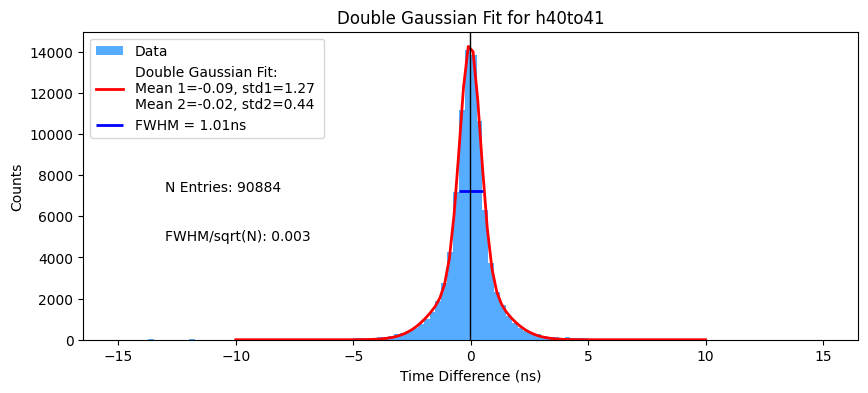

Combined Mean (mean1-2): -0.034
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 79.267
(A1, A2): (9390.116283870662, 12786.567065264746)
Peak of the double Gaussian occurs at x = -0.20 with height = 16789.69


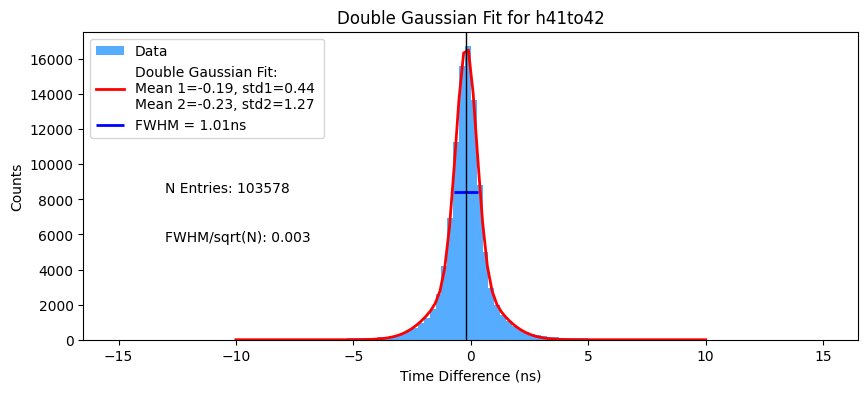

Combined Mean (mean1-2): -0.197
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 25.086
(A1, A2): (15061.230888304619, 10185.23910563365)
Peak of the double Gaussian occurs at x = -0.29 with height = 14189.57


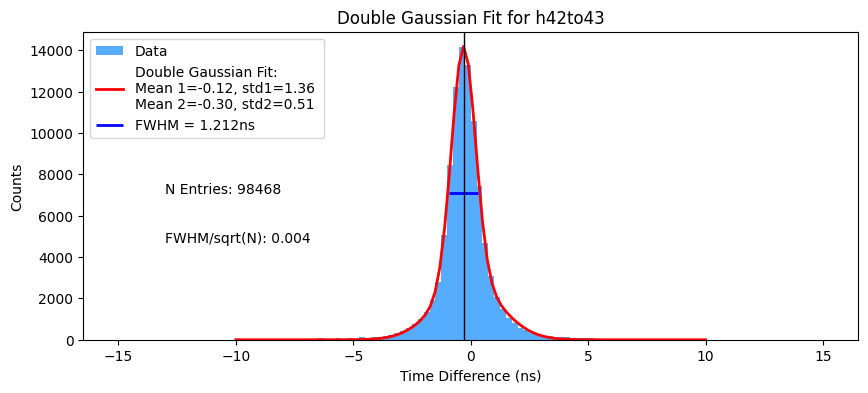

Combined Mean (mean1-2): -0.270
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 451.389
(A1, A2): (9346.789637401727, 14675.36438172097)
Peak of the double Gaussian occurs at x = -0.23 with height = 10722.70


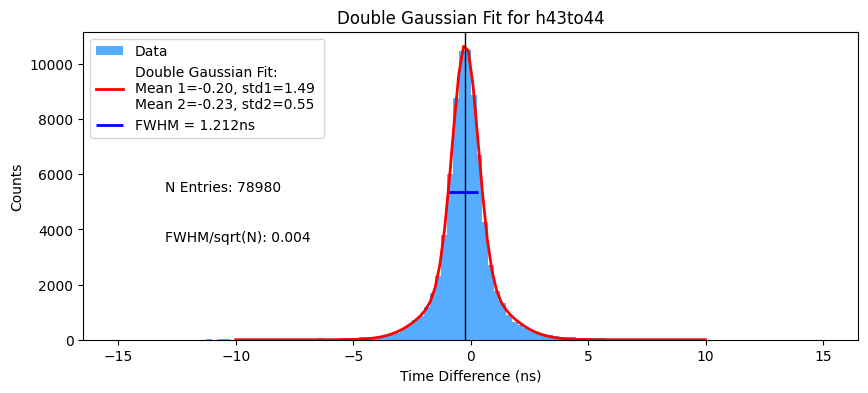

Combined Mean (mean1-2): -0.223
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 8.739
(A1, A2): (7397.630369330056, 11945.883622482726)
Peak of the double Gaussian occurs at x = -0.83 with height = 6201.29


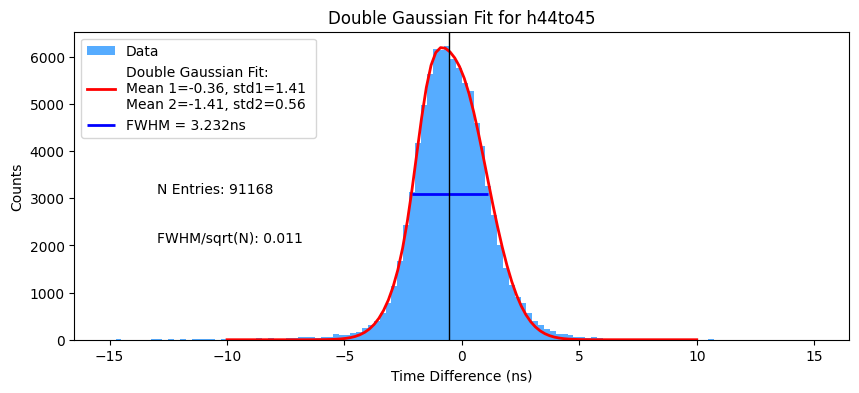

Combined Mean (mean1-2): -0.540
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 7131.979
(A1, A2): (20511.349177983684, 1715.4625925549526)
Peak of the double Gaussian occurs at x = -0.98 with height = 5191.99


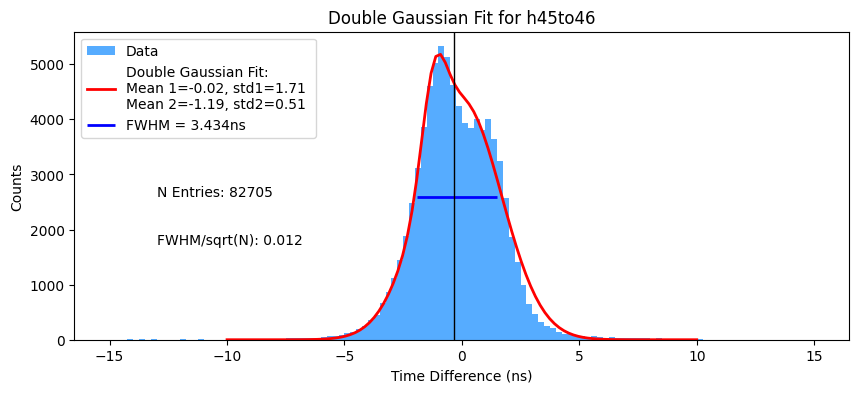

Combined Mean (mean1-2): -0.341
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 10191.631
(A1, A2): (18529.053599791987, 2076.541193414686)
Peak of the double Gaussian occurs at x = -0.14 with height = 11119.73


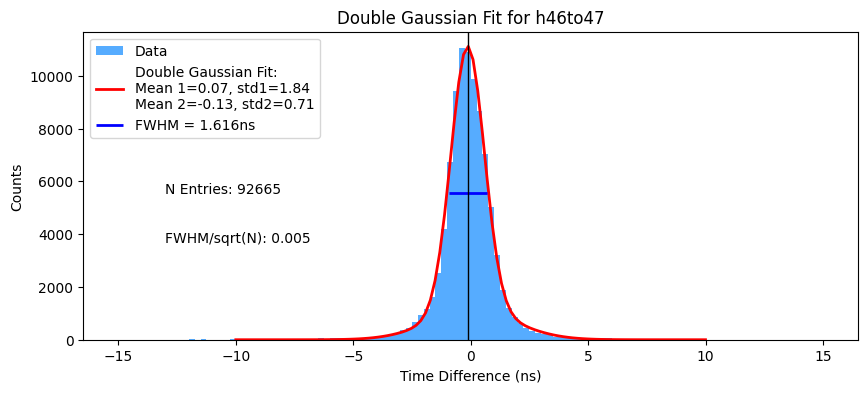

Combined Mean (mean1-2): -0.110
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 235.252
(A1, A2): (4939.881289180822, 17914.49255606628)
Peak of the double Gaussian occurs at x = 0.20 with height = 17703.49


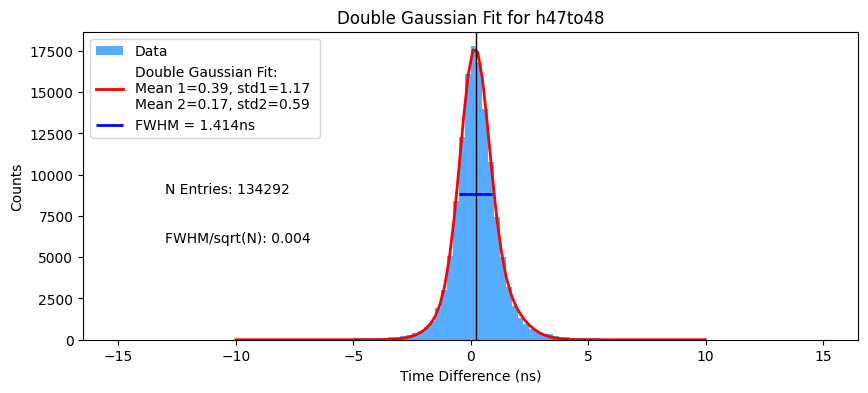

Combined Mean (mean1-2): 0.224
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 1048.208
(A1, A2): (12965.122629350906, 19799.3080615331)
Peak of the double Gaussian occurs at x = 0.41 with height = 19986.86


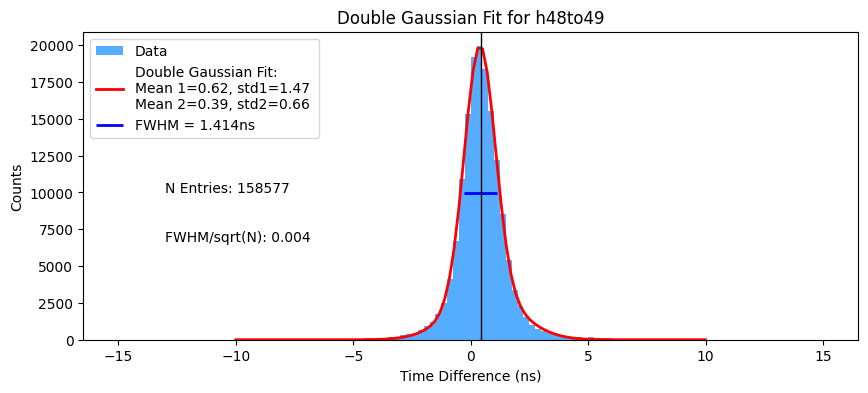

Combined Mean (mean1-2): 0.425
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 806.513
(A1, A2): (10890.567028847152, 28055.335493780727)
Peak of the double Gaussian occurs at x = 0.62 with height = 16891.07


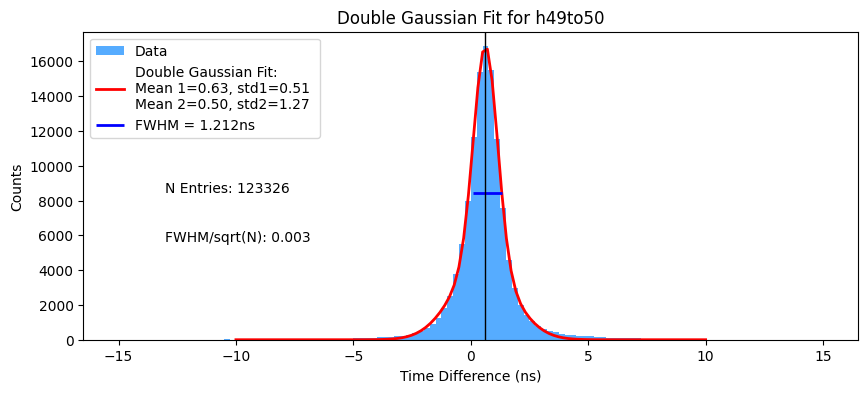

Combined Mean (mean1-2): 0.595
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 347.370
(A1, A2): (15961.060901204683, 13755.23112437303)
Peak of the double Gaussian occurs at x = 0.26 with height = 15524.96


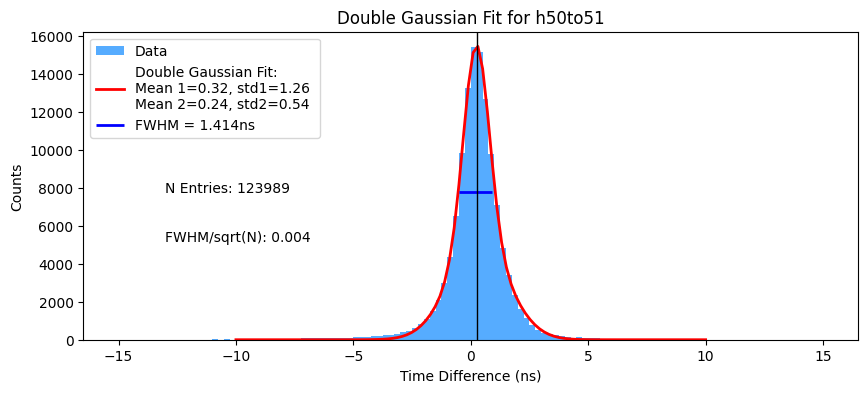

Combined Mean (mean1-2): 0.265
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 163.459
(A1, A2): (15533.018609241364, 14485.798026490045)
Peak of the double Gaussian occurs at x = -0.08 with height = 14468.80


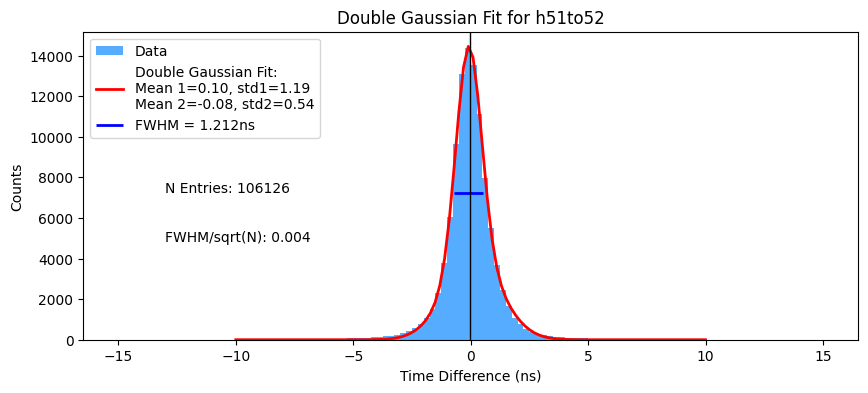

Combined Mean (mean1-2): -0.034
Uncertainty in Combined Mean: 0.003
Chi-Squared/DOF: 561.552
(A1, A2): (11506.783235387613, 14288.737547188231)
Peak of the double Gaussian occurs at x = -0.26 with height = 9910.58


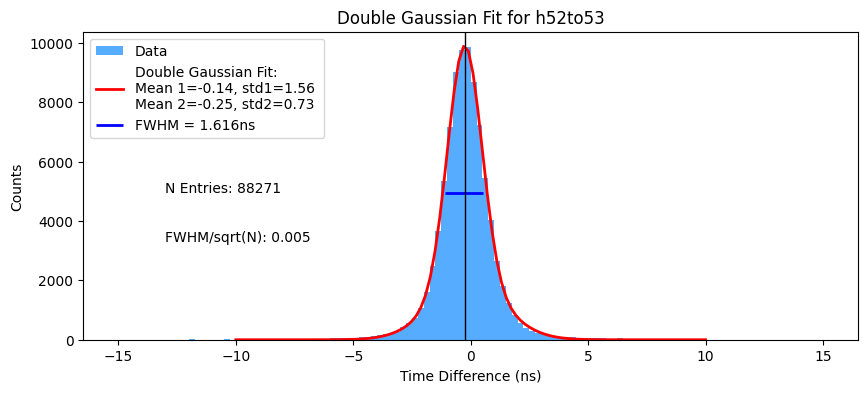

Combined Mean (mean1-2): -0.233
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 113.258
(A1, A2): (6900.787199710996, 14809.55860814862)
Peak of the double Gaussian occurs at x = -0.56 with height = 6845.61


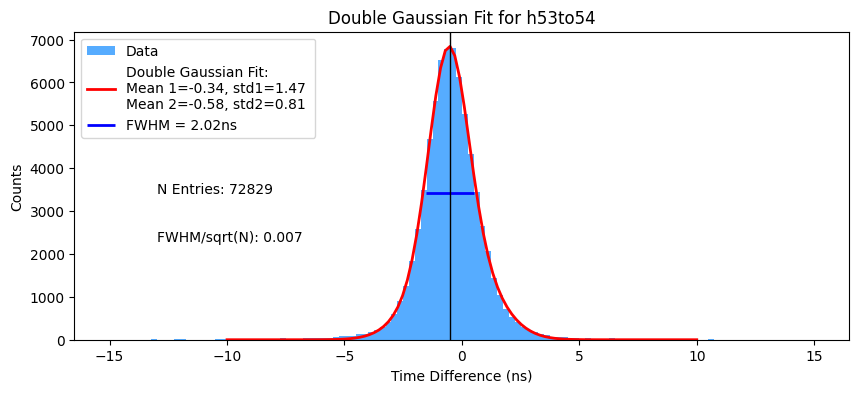

Combined Mean (mean1-2): -0.494
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 551.654
(A1, A2): (8699.417891836258, 9158.242281298506)
Peak of the double Gaussian occurs at x = -0.02 with height = 5884.90


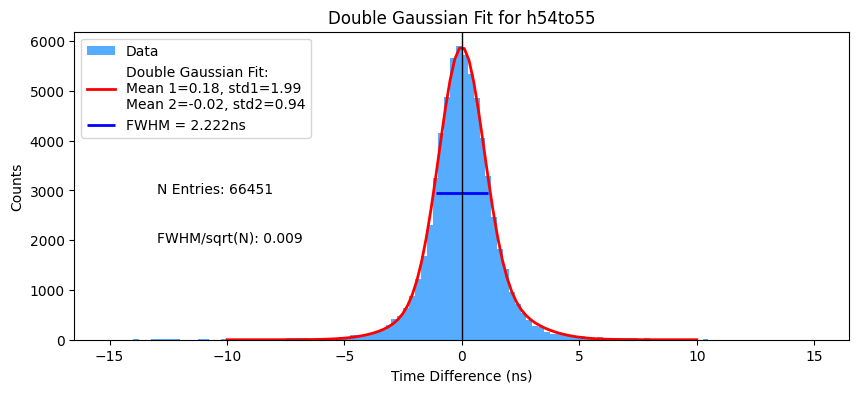

Combined Mean (mean1-2): 0.016
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 193.687
(A1, A2): (4736.630991937707, 11665.514793442557)
Peak of the double Gaussian occurs at x = 0.20 with height = 8112.41


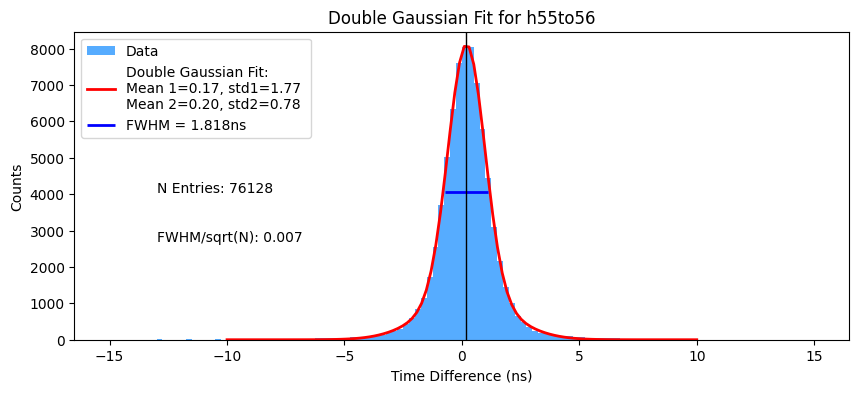

Combined Mean (mean1-2): 0.193
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 3.544
(A1, A2): (5157.703191193691, 13585.820697579447)
Peak of the double Gaussian occurs at x = 0.62 with height = 886.93


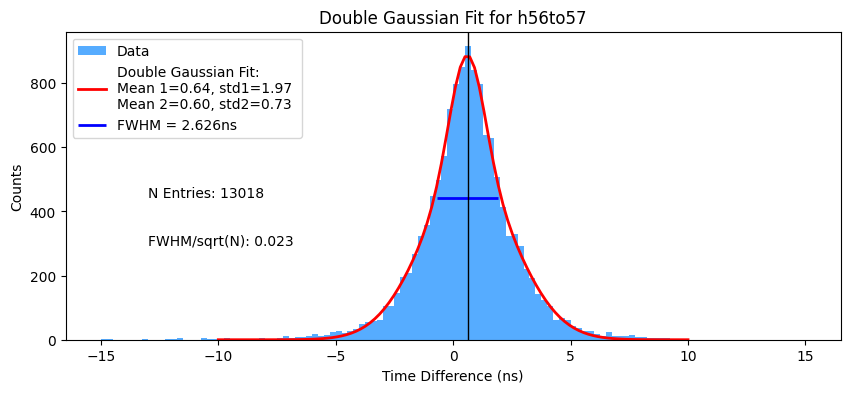

Combined Mean (mean1-2): 0.621
Uncertainty in Combined Mean: 0.013
Chi-Squared/DOF: 2.643
(A1, A2): (2475.286601484473, 708.7689976864956)
Peak of the double Gaussian occurs at x = 0.17 with height = 704.98


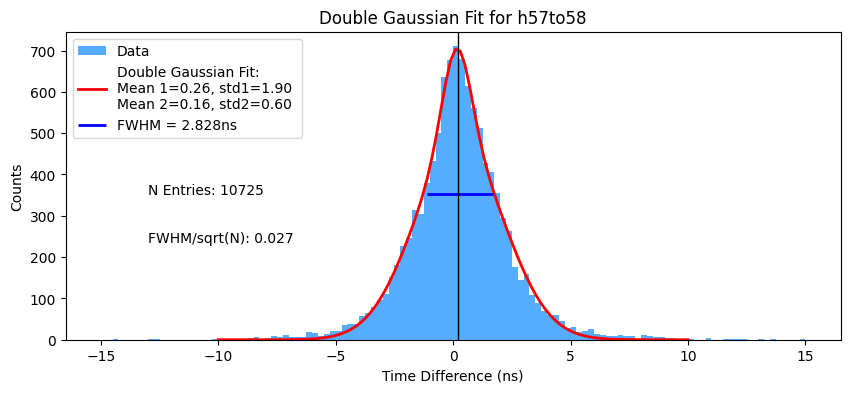

Combined Mean (mean1-2): 0.224
Uncertainty in Combined Mean: 0.015
Chi-Squared/DOF: 10.408
(A1, A2): (2248.735873722746, 351.59786834386915)
Peak of the double Gaussian occurs at x = 0.17 with height = 12604.45


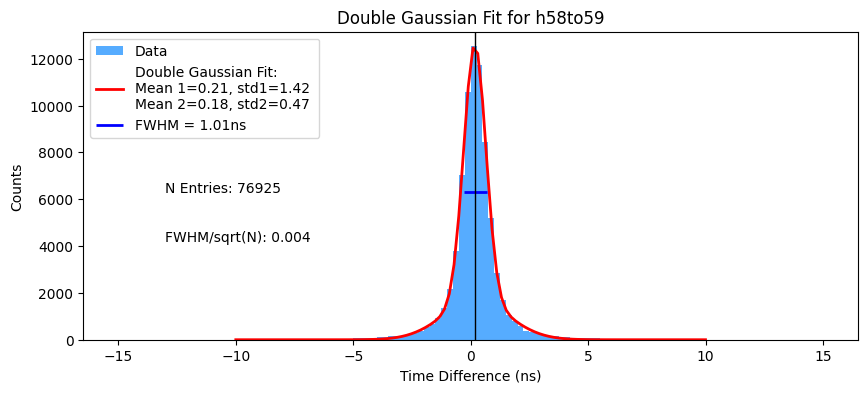

Combined Mean (mean1-2): 0.182
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 9.301
(A1, A2): (5775.888369459395, 12981.481011221758)
Peak of the double Gaussian occurs at x = 0.35 with height = 9473.35


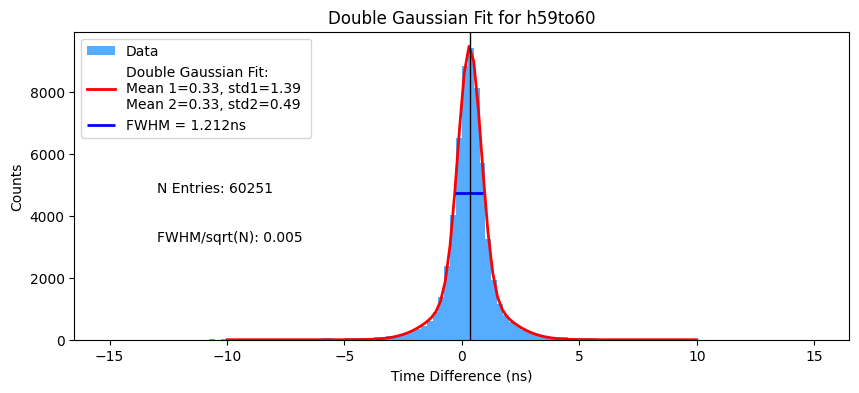

Combined Mean (mean1-2): 0.331
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 0.040
(A1, A2): (4710.531406604945, 10004.11740886639)
Peak of the double Gaussian occurs at x = 0.20 with height = 9537.27


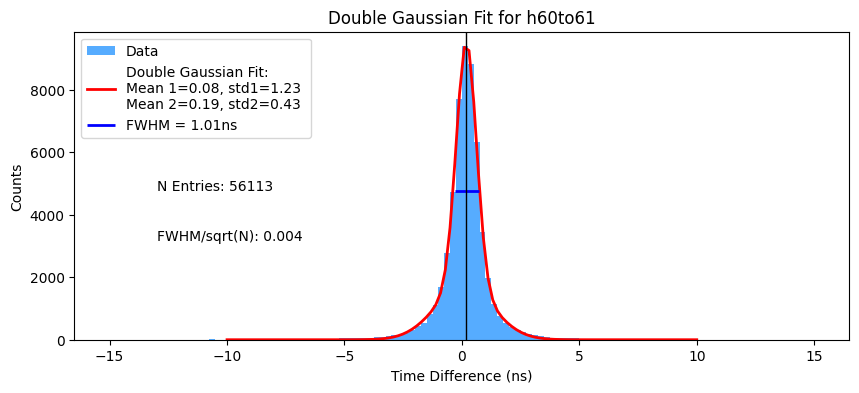

Combined Mean (mean1-2): 0.174
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 100.523
(A1, A2): (5160.272483469902, 8472.73523272098)
Peak of the double Gaussian occurs at x = 0.11 with height = 11446.32


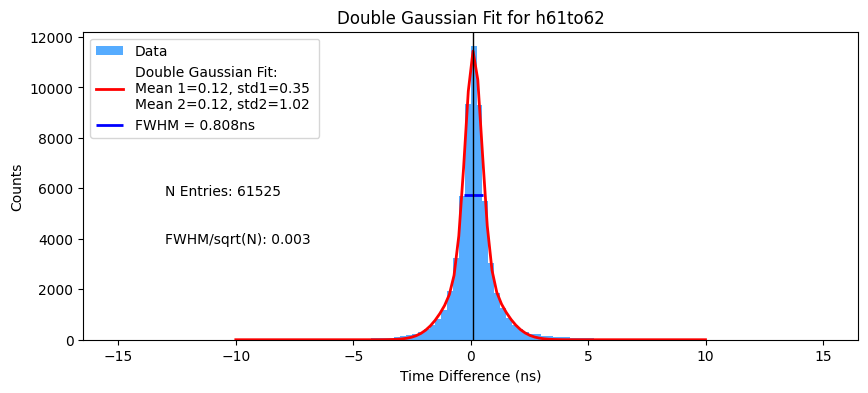

Combined Mean (mean1-2): 0.119
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 0.063
(A1, A2): (7707.806773323797, 7045.110943165275)
Peak of the double Gaussian occurs at x = 0.20 with height = 9756.35


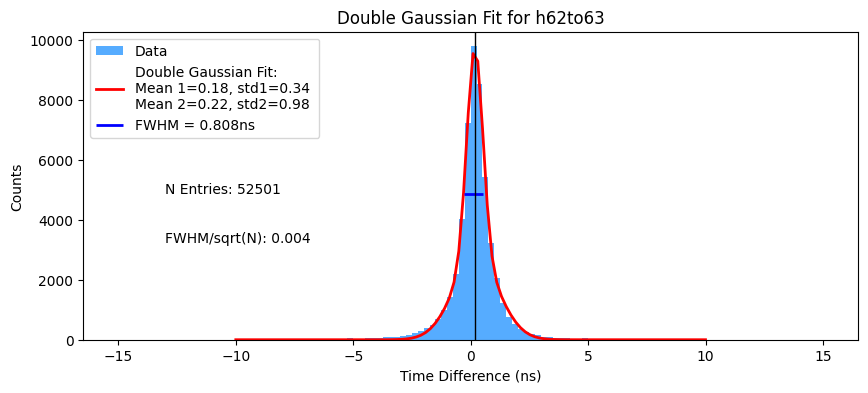

Combined Mean (mean1-2): 0.192
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 23.709
(A1, A2): (6108.707267599575, 6465.235063227997)
Peak of the double Gaussian occurs at x = 0.05 with height = 9570.86


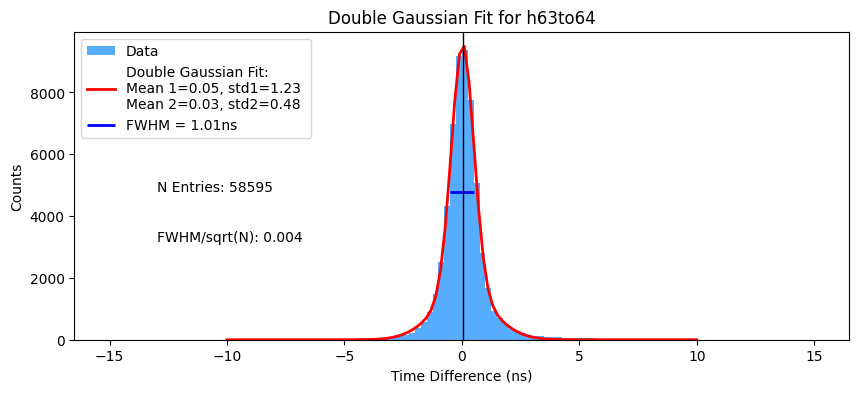

Combined Mean (mean1-2): 0.036
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 2.242
(A1, A2): (4618.107093274959, 9651.975039012195)
Peak of the double Gaussian occurs at x = -0.83 with height = 12050.17


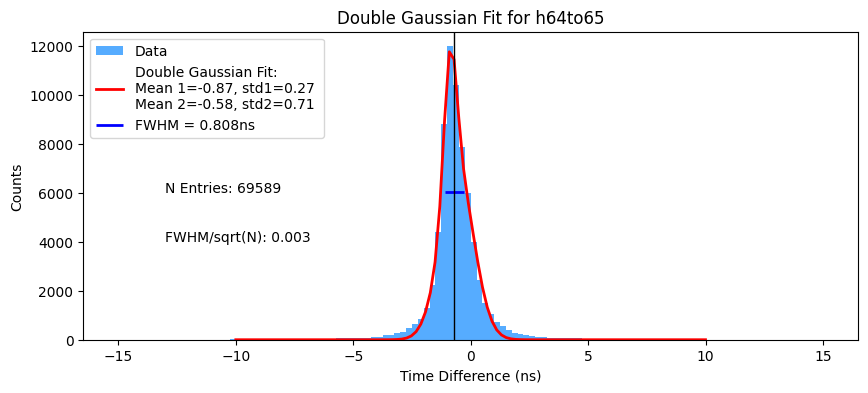

Combined Mean (mean1-2): -0.709
Uncertainty in Combined Mean: 0.004
Chi-Squared/DOF: 1678.598
(A1, A2): (3766.2917479988487, 12251.14322768255)
Peak of the double Gaussian occurs at x = -1.07 with height = 5773.59


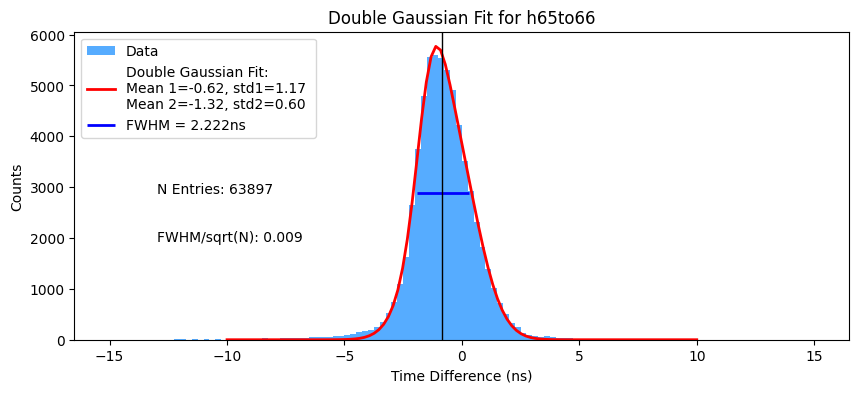

Combined Mean (mean1-2): -0.846
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 4114.675
(A1, A2): (12448.649250434752, 3017.594653579167)
Peak of the double Gaussian occurs at x = -1.28 with height = 4394.38


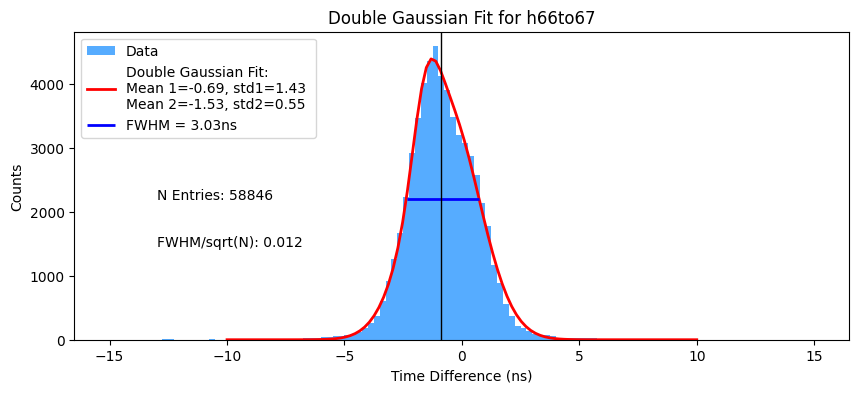

Combined Mean (mean1-2): -0.901
Uncertainty in Combined Mean: 0.006
Chi-Squared/DOF: 3960.239
(A1, A2): (12973.499987952167, 1643.7679061715778)
Peak of the double Gaussian occurs at x = -0.47 with height = 4826.15


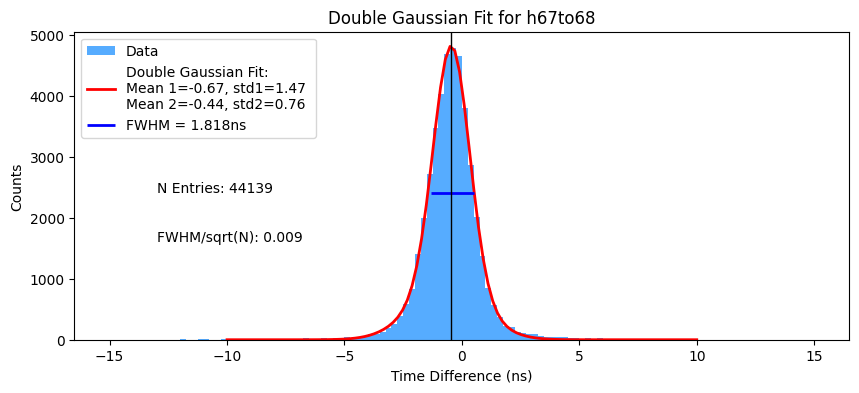

Combined Mean (mean1-2): -0.481
Uncertainty in Combined Mean: 0.006
Chi-Squared/DOF: 232.558
(A1, A2): (3202.2350113138573, 7600.372490781644)
Peak of the double Gaussian occurs at x = -1.13 with height = 7343.73


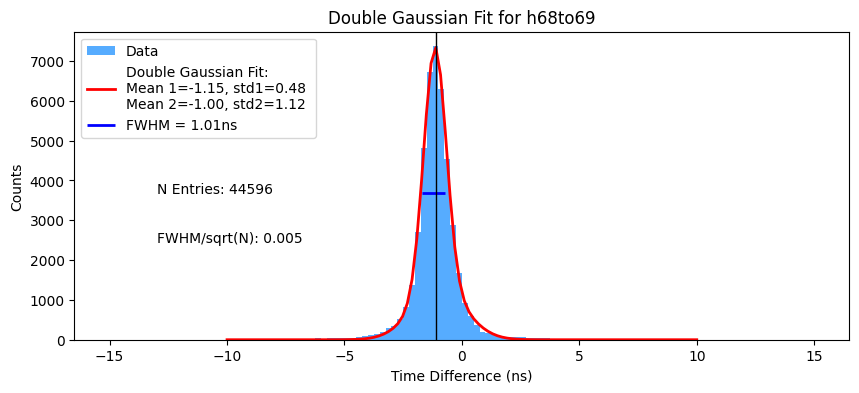

Combined Mean (mean1-2): -1.120
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 143.436
(A1, A2): (7296.7404536995855, 3528.1360277757)
Peak of the double Gaussian occurs at x = -1.19 with height = 4523.16


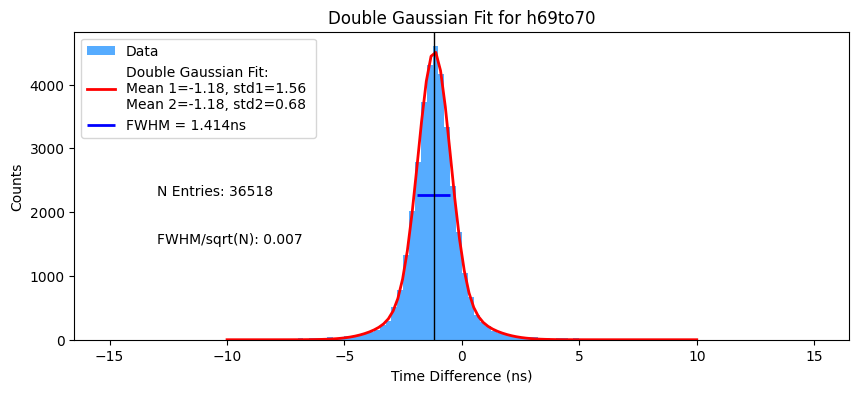

Combined Mean (mean1-2): -1.178
Uncertainty in Combined Mean: 0.006
Chi-Squared/DOF: 0.020
(A1, A2): (2259.4991301949926, 6718.818922742087)
Peak of the double Gaussian occurs at x = -1.19 with height = 1383.61


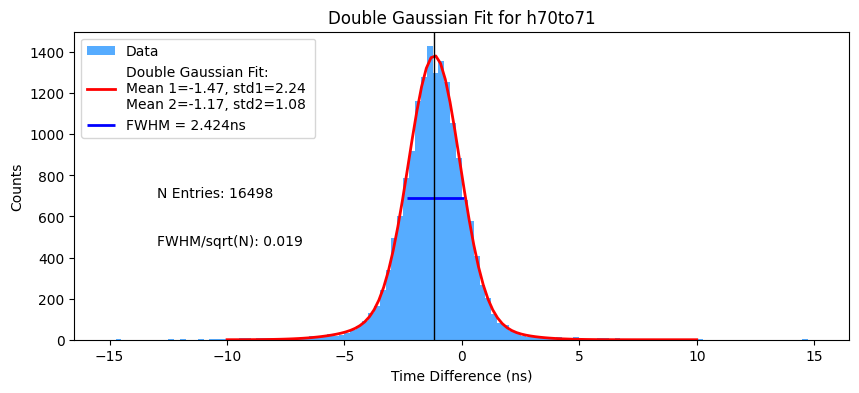

Combined Mean (mean1-2): -1.195
Uncertainty in Combined Mean: 0.011
Chi-Squared/DOF: 60.216
(A1, A2): (658.3674055274105, 3438.084511930713)
Peak of the double Gaussian occurs at x = 0.26 with height = 1421.95


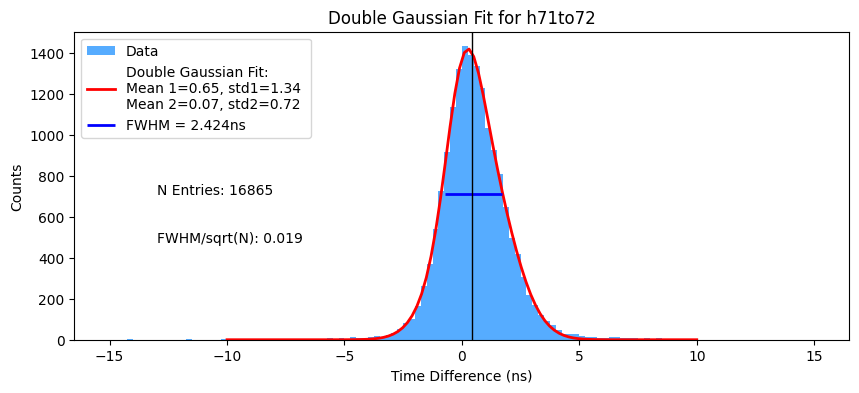

Combined Mean (mean1-2): 0.438
Uncertainty in Combined Mean: 0.010
Chi-Squared/DOF: 713.878
(A1, A2): (3169.8513583836257, 964.2624067932301)
Peak of the double Gaussian occurs at x = -0.17 with height = 3259.83


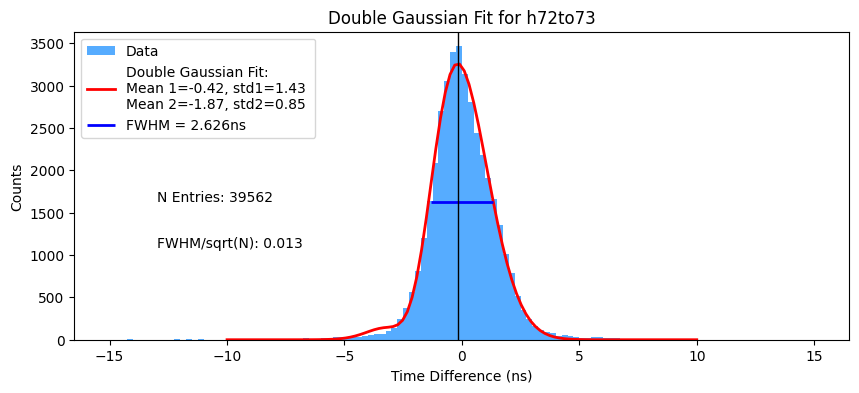

Combined Mean (mean1-2): -0.808
Uncertainty in Combined Mean: 0.006
Chi-Squared/DOF: 12279.476
(A1, A2): (12455.417140221994, -2703.3621393602857)
Peak of the double Gaussian occurs at x = 0.56 with height = 6366.80


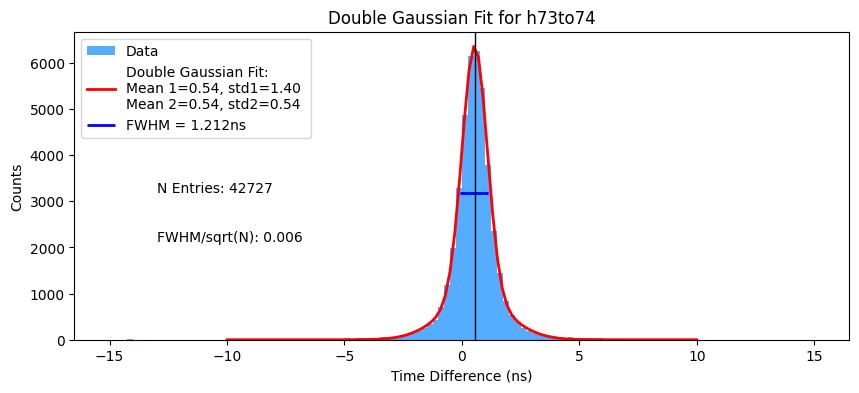

Combined Mean (mean1-2): 0.543
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 0.104
(A1, A2): (3105.71586068065, 7363.6984619191)
Peak of the double Gaussian occurs at x = 0.41 with height = 5426.10


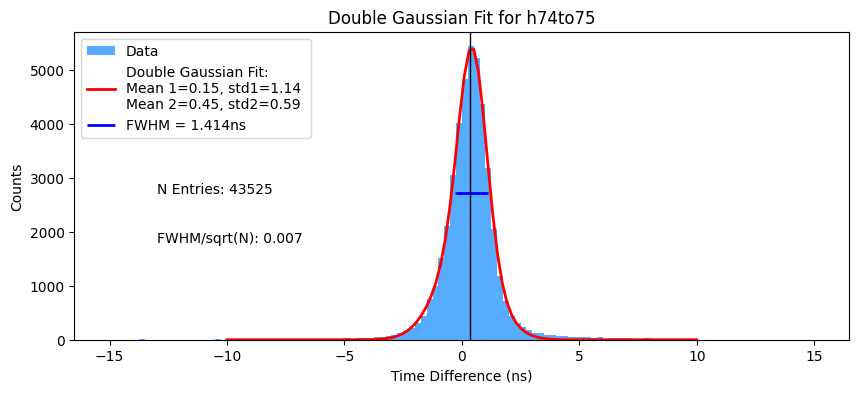

Combined Mean (mean1-2): 0.356
Uncertainty in Combined Mean: 0.005
Chi-Squared/DOF: 689.540
(A1, A2): (4908.311058937203, 5598.124900702579)
Peak of the double Gaussian occurs at x = 0.11 with height = 3910.81


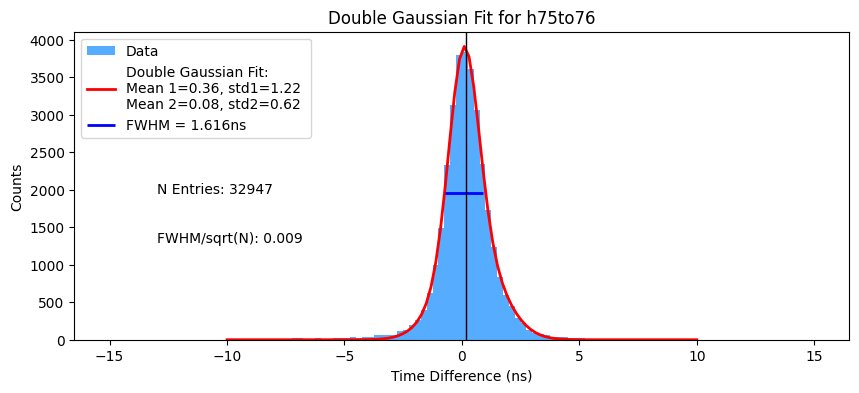

Combined Mean (mean1-2): 0.170
Uncertainty in Combined Mean: 0.006
Chi-Squared/DOF: 409.382
(A1, A2): (3857.523416168037, 4163.270105090375)
Peak of the double Gaussian occurs at x = 0.14 with height = 23.04


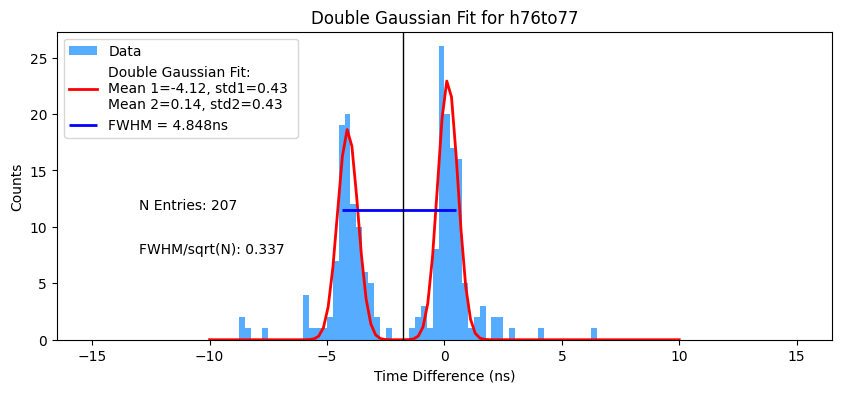

Combined Mean (mean1-2): -1.763
Uncertainty in Combined Mean: 0.062
Chi-Squared/DOF: 1175.765
(A1, A2): (20.2125194821902, 24.803946122575894)
Peak of the double Gaussian occurs at x = -0.80 with height = 19.61


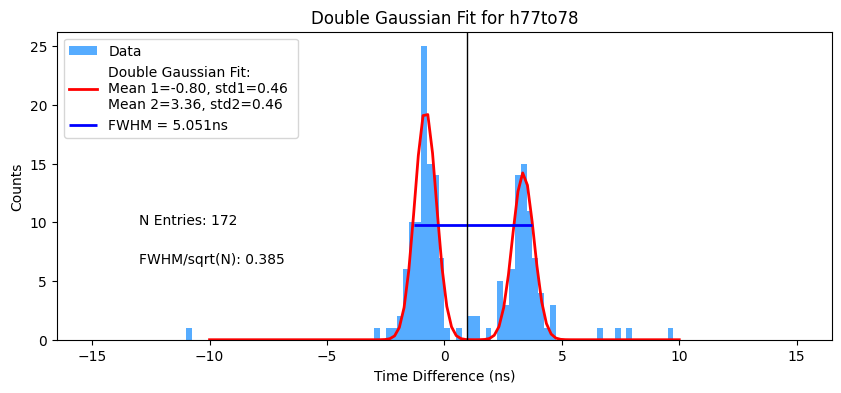

Combined Mean (mean1-2): 0.945
Uncertainty in Combined Mean: 0.069
Chi-Squared/DOF: 896.057
(A1, A2): (22.644786150563004, 16.32033374959406)
Peak of the double Gaussian occurs at x = -1.94 with height = 817.47


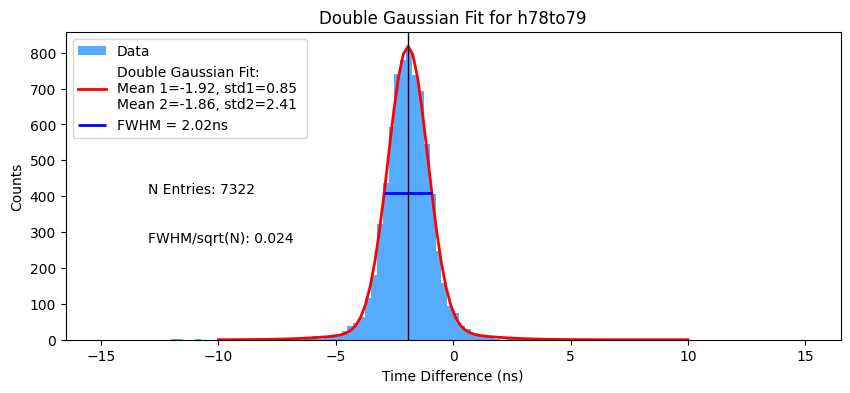

Combined Mean (mean1-2): -1.920
Uncertainty in Combined Mean: 0.014
Chi-Squared/DOF: 0.547
(A1, A2): (1685.7219266678242, 140.91596363700083)
Peak of the double Gaussian occurs at x = 1.43 with height = 309.62


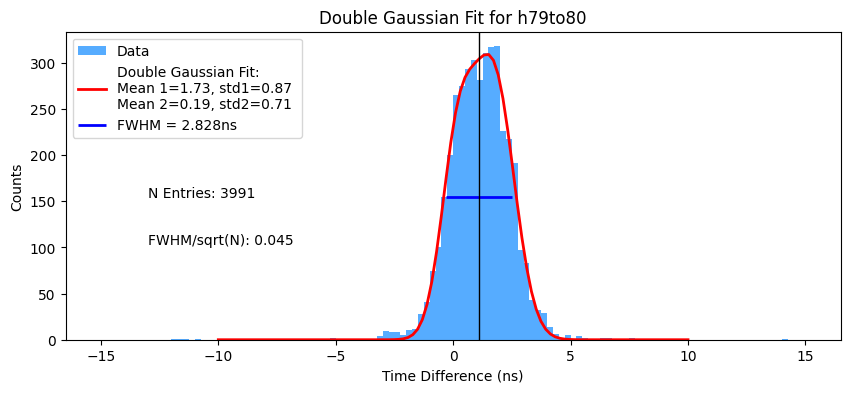

Combined Mean (mean1-2): 1.096
Uncertainty in Combined Mean: 0.018
Chi-Squared/DOF: 1751.640
(A1, A2): (619.9173679219058, 351.5829600792288)
Peak of the double Gaussian occurs at x = -1.76 with height = 91.81


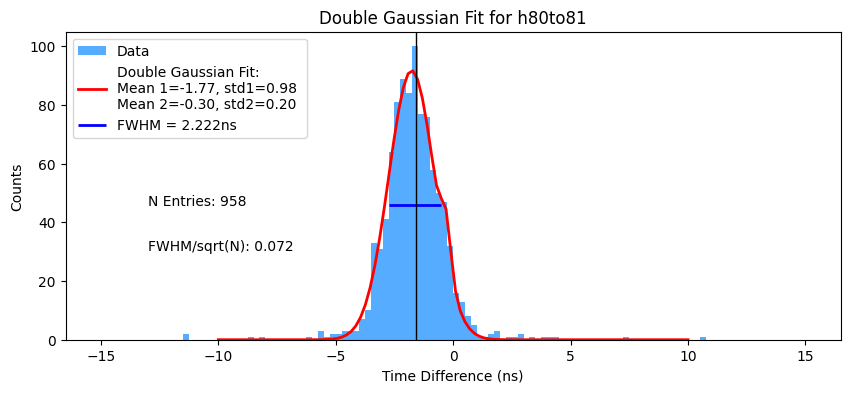

Combined Mean (mean1-2): -1.564
Uncertainty in Combined Mean: 0.039
Chi-Squared/DOF: 172.100
(A1, A2): (224.6075385040138, 7.230970407014187)
Peak of the double Gaussian occurs at x = -0.26 with height = 33.72


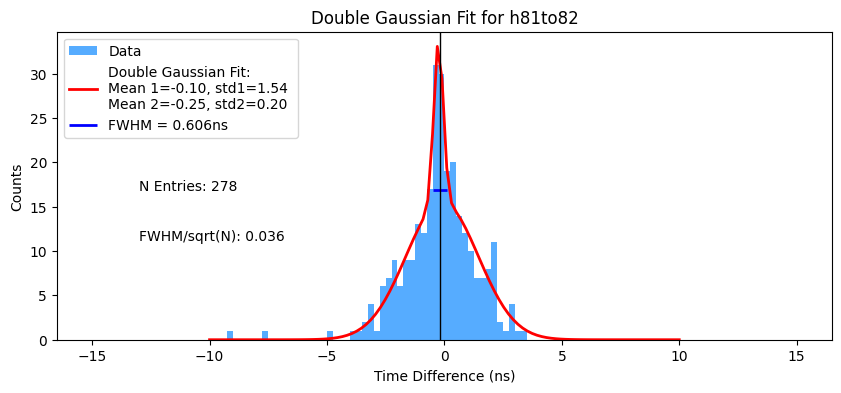

Combined Mean (mean1-2): -0.180
Uncertainty in Combined Mean: 0.069
Chi-Squared/DOF: 1.252
(A1, A2): (60.01233505444542, 9.231152699255226)
Peak of the double Gaussian occurs at x = 2.24 with height = 7.56


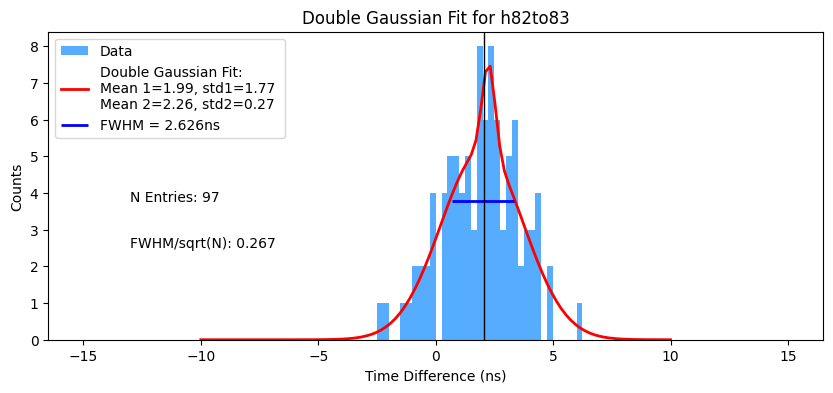

Combined Mean (mean1-2): 2.075
Uncertainty in Combined Mean: 0.145
Chi-Squared/DOF: 0.770
(A1, A2): (22.910799638610968, 1.6606578688556484)
Peak of the double Gaussian occurs at x = -3.17 with height = 0.20


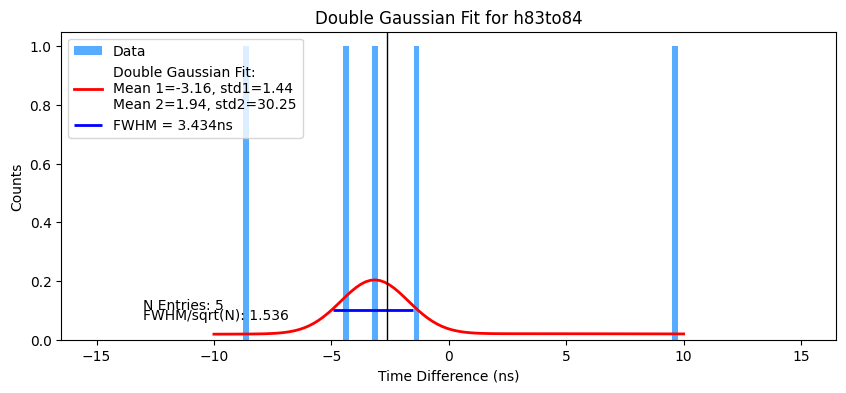

Combined Mean (mean1-2): -2.645
Uncertainty in Combined Mean: 0.883
Chi-Squared/DOF: 3.010
(A1, A2): (0.6616314252414166, 1.552277583182164)
Peak of the double Gaussian occurs at x = 8.12 with height = 1.00


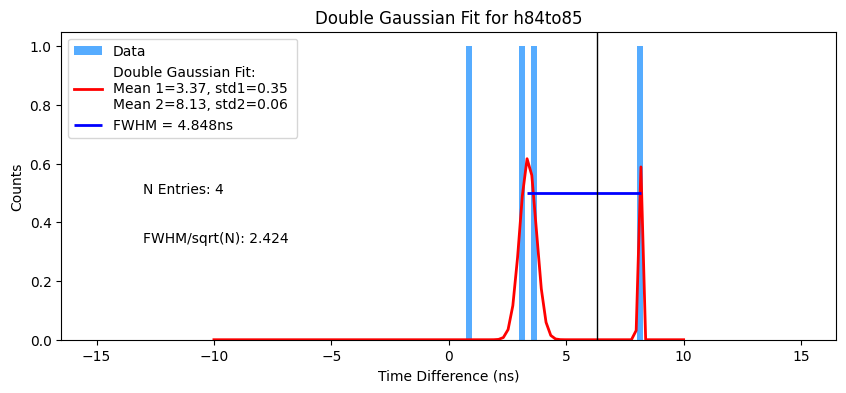

Combined Mean (mean1-2): 6.305
Uncertainty in Combined Mean: 0.313
Chi-Squared/DOF: 54.330
(A1, A2): (0.550713428259712, 0.13843153290712357)
Peak of the double Gaussian occurs at x = 0.26 with height = 4.38


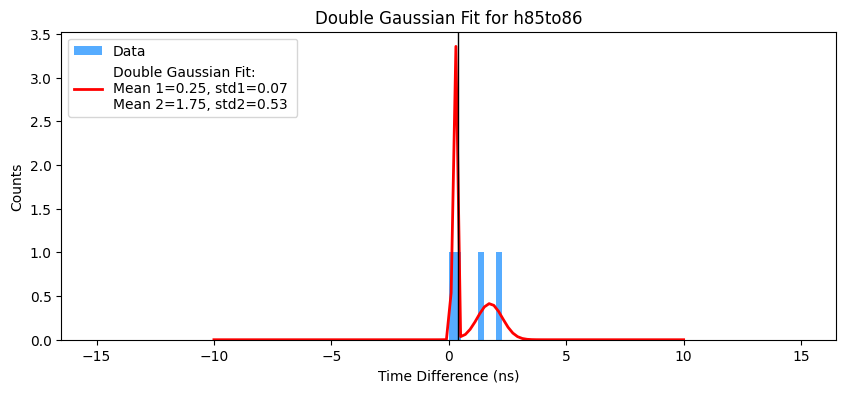

Combined Mean (mean1-2): 0.379
Uncertainty in Combined Mean: 0.182
Chi-Squared/DOF: 5.342
(A1, A2): (0.7967636501581045, 0.5515051261961477)
Peak of the double Gaussian occurs at x = -15.00 with height = nan


/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:409: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/research/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/research/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:414: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


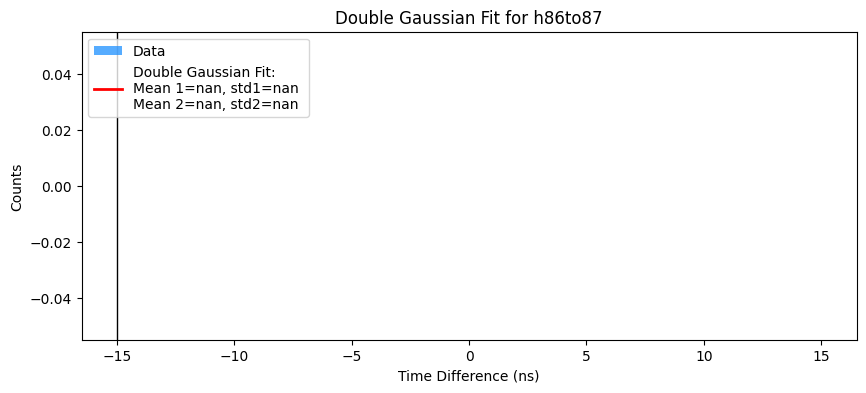

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
Peak of the double Gaussian occurs at x = -15.00 with height = nan


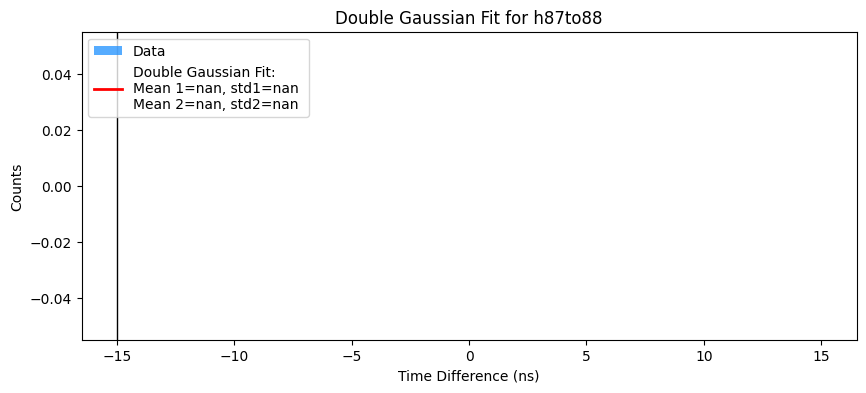

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)
Peak of the double Gaussian occurs at x = -15.00 with height = nan


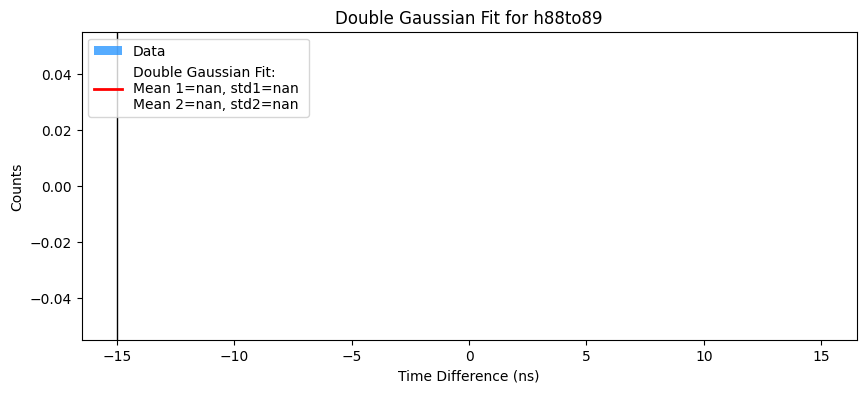

Combined Mean (mean1-2): nan
Uncertainty in Combined Mean: nan
Chi-Squared/DOF: nan
(A1, A2): (0.0, 0.0)


In [34]:
peak=[]
for i in range(0,len(histogramPath)):
    peak.append(plot_histogram_with_double_gaussian(histograms, histogramPath[i]))
    

# Path Offset Calculation

In [285]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to plot a histogram and fit a Gaussian to it
def get_histogram_with_gaussian(histograms, hist_name):
    if hist_name in histograms:
        datah = histograms[hist_name]
        
        # Filter the data to only include values in the range [-30, 30]
        data = datah[(datah >= -10) & (datah <= 10)]
        
       
        
        # Fit a Gaussian to the filtered data
        mu, std = norm.fit(data)
        
        # Generate the fitted Gaussian curve
        x = np.linspace(-10, 10, 100)
        p = norm.pdf(x, mu, std)
        
        # Plot the fitted Gaussian curve
        #plt.plot(x, p, 'k', linewidth=2, label=f'mean={mu:.2f}, std={std:.2f}')
        #plt.hist(datah, bins=60, alpha=0.75, range=(-30, 30), density=True, label='Data')
        # Add labels and title
        #plt.title(f"Histogram and Gaussian Fit for {hist_name}")
        #plt.xlabel('Time Difference (ns)')
        #plt.ylabel("Normalized")
        #plt.legend()
        
        # Show the plot
        return [mu,std,np.sqrt(len(data))]
    else:
        print(f"Histogram {hist_name} not found!")



def get_histogram_with_gaussian_secondary(histograms, hist_name):
    if hist_name in histograms:
        datah = histograms[hist_name]
        
        # Filter the data to only include values in the range [-10, 10]
        data = datah[(datah >= -10) & (datah <= 10)]
        
        # First Gaussian fit to the filtered data
        mu, std = norm.fit(data)
        
        # Perform a secondary fit using data within one standard deviation of the first mean
        data_secondary = data[(data >= mu - std) & (data <= mu + std)]
        
        # Fit a Gaussian to the secondary filtered data
        mu_secondary, std_secondary = norm.fit(data_secondary)
        return [mu_secondary, std,np.sqrt(len(data))]
    else:
        print(f"Histogram {hist_name} not found!")
        return None

    
    
def get_histogram_with_double_gaussian(histograms, hist_name):
    if hist_name in histograms:
        datah = histograms[hist_name]
        #plt.figure(figsize=(10, 4))
        # Filter the data to only include values in the range [-10, 10]
        data = datah[(datah >= -10) & (datah <= 10)]
        nEntries=len(data)
        # Plot the histogram of the original data with counts on the y-axis
        counts, bins = np.histogram(data, bins=120, range=(-15, 15))
        bin_width = bins[1] - bins[0]        
        
        # Use bin centers for fitting
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Initial guesses for the parameters of the double Gaussian
        mu1_initial, sigma1_initial = norm.fit(data)
        mu2_initial, sigma2_initial = mu1_initial + 1, sigma1_initial
        A1_initial, A2_initial = max(counts) * bin_width, max(counts) * bin_width / 2  # Scale amplitudes to match the histogram
        
        initial_guess = [mu1_initial, sigma1_initial, A1_initial, mu2_initial, sigma2_initial, A2_initial]
        
        # Fit the double Gaussian to the data
        popt, _ = curve_fit(double_gaussian, bin_centers, counts, p0=initial_guess)
        mu1, sigma1, A1, mu2, sigma2, A2 = popt
        peak_x, peak_y = find_peak_of_double_gaussian(mu1, sigma1, A1, mu2, sigma2, A2)
        #print(f"Peak of the double Gaussian occurs at x = {peak_x:.2f} with height = {peak_y:.2f}")
        # Generate the fitted double Gaussian curve
        x = np.linspace(-10, 10, 100)
        p_double_gaussian = double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2)
        left_fwhm, right_fwhm, fwhm_value,half_max = calculate_fwhm(x, p_double_gaussian, peak_y)

        if fwhm_value!=None:
            error=fwhm_value/np.sqrt(nEntries)
        else:
            error=100
        # Plot the fitted double Gaussian curve
        #plt.plot(x, p_double_gaussian, 'r', linewidth=2, label=f'Double Gaussian Fit: \nmean1={mu1:.2f}, std1={sigma1:.2f} \nmean2={mu2:.2f}, std2={sigma2:.2f}')
        
        # Add labels and title
        #plt.title(f"Double Gaussian Fit for {hist_name}")
       # #plt.xlabel('Time Difference (ns)')
        #plt.ylabel("Counts")
        #plt.axvline(peak_x,color='black',lw=1,label=f"Peak: {np.round(peak_x,3)}ns")

        #plt.legend(loc='upper left')
        # Show the plot
       # plt.show()
    # Step 1: Calculate the number of events under each Gaussian
        N1 = abs(A1) * np.sqrt(2 * np.pi) * sigma1  # Number of events under Gaussian 1
        N2 = abs(A2) * np.sqrt(2 * np.pi) * sigma2  # Number of events under Gaussian 2
        
        # Step 2: Calculate the accuracy as standard error
        accuracy1 = sigma1 / np.sqrt(N1)  # Standard error (accuracy) for Gaussian 1
        accuracy2 = sigma2 / np.sqrt(N2)  # Standard error (accuracy) for Gaussian 2
        
        # Step 3: Calculate the combined weighted mean (mean1-2)
        mean1_2 = (mu1 / accuracy1**2 + mu2 / accuracy2**2) / (1 / accuracy1**2 + 1 / accuracy2**2)
        
        # Step 4: Calculate the uncertainty in the combined mean
        sigma_mean1_2 = 1 / np.sqrt(1 / accuracy1**2 + 1 / accuracy2**2)
        
        # Step 5: Chi-squared calculation for the combined mean
        chi_squared = ((mu1 - mean1_2)**2 / accuracy1**2) + ((mu2 - mean1_2)**2 / accuracy2**2)
        if A1>0 and A2>0:
            return mean1_2,sigma_mean1_2
        else:
            return peak_x,error
        """return {
            'mu1': mu1,
            'sigma1': sigma1,
            'A1': A1,
            'mu2': mu2,
            'sigma2': sigma2,
            'A2': A2
        """
    else:
        print(f"Histogram {hist_name} not found!")

# Example usage:
# Example usage:
# primary_fit, secondary_fit = get_histogram_with_gaussian_secondary(histograms, 'h152to151')


In [286]:
mean=[]
error=[]
for i in range(0,len(histogramPath)):
    result=get_histogram_with_double_gaussian(histograms, histogramPath[i])
    mean.append(result[0])
    error.append(result[1])

In [287]:
np.sum(mean)

-29.9777477570572

In [288]:
target_block

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88])

In [289]:
#old fits

"""master_block = 45
target_block = np.arange(0,89)
id_offset=[]
for i in target_block:
    mean=[]
    error=[]
    if i == master_block:
        continue
    
    path = find_path_to_block_1d(master_block, i)  # Assume you already have the path function
    print(path)
    #draw_grid_with_path(master_block, i, path)
    histogramPath= ['h' + p for p in path]
    for j in range(0,len(histogramPath)):
        result=get_histogram_with_gaussian_secondary(histograms, histogramPath[j])
        mean.append(result[0])
        error.append(0)
    npError=np.array(error)    
    offset=np.sum(mean)
    e=np.sqrt(np.sum(npError**2))
    id_offset.append([i,offset,e])"""

"master_block = 45\ntarget_block = np.arange(0,89)\nid_offset=[]\nfor i in target_block:\n    mean=[]\n    error=[]\n    if i == master_block:\n        continue\n    \n    path = find_path_to_block_1d(master_block, i)  # Assume you already have the path function\n    print(path)\n    #draw_grid_with_path(master_block, i, path)\n    histogramPath= ['h' + p for p in path]\n    for j in range(0,len(histogramPath)):\n        result=get_histogram_with_gaussian_secondary(histograms, histogramPath[j])\n        mean.append(result[0])\n        error.append(0)\n    npError=np.array(error)    \n    offset=np.sum(mean)\n    e=np.sqrt(np.sum(npError**2))\n    id_offset.append([i,offset,e])"

In [290]:
master_block = 45
target_block = np.arange(0, 89)
id_offset = []

for i in target_block:
    mean = []
    error = []

    if i == master_block:
        continue

    path = find_path_to_block_1d(master_block, i)  # Assume you already have the path function
    print(path)
    # draw_grid_with_path(master_block, i, path)
    histogramPath = ['h' + p for p in path]

    for j in range(0, len(histogramPath)):
        try:
            # Try to get the result using the double Gaussian fit
            result = get_histogram_with_double_gaussian(histograms, histogramPath[j])
            if result is not None:
                mean.append(result[0])  # Append the result (peak_x) if the fit succeeds
                error.append(result[1])  # Placeholder error for now, change as needed
            else:
                mean.append(0)  # If no result (None), append 0 as placeholder
                error.append(100)  # Placeholder error, 0 for now
        except RuntimeError:
            # If the curve_fit function fails, append 0 as a placeholder for both mean and error
            print(f"Fit failed for {histogramPath[j]}, adding 0 as a placeholder.")
            mean.append(0)  # Append 0 for the failed fit
            error.append(100)  # Append 0 for the error

    # Convert error list to numpy array for calculations
    npError = np.array(error)

    # Calculate the offset and error using numpy functions
    offset = np.sum(mean)  # Sum of the means
    e = np.sqrt(np.sum(npError**2))  # Combined error (currently 0 but ready for real error)

    # Append the id, offset, and error to the result list
    id_offset.append([i, offset, e])

# id_offset now contains the offsets and errors for all target blocks


['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26', '26to25', '25to24', '24to23', '23to22', '22to21', '21to20', '20to19', '19to18', '18to17', '17to16', '16to15', '15to14', '14to13', '13to12', '12to11', '11to10', '10to9', '9to8', '8to7', '7to6', '6to5', '5to4', '4to3', '3to2', '2to1', '1to0']
Fit failed for h2to1, adding 0 as a placeholder.
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26', '26to25', '25to24', '24to23', '23to22', '22to21', '21to20', '20to19', '19to18', '18to17', '17to16', '16to15', '15to14', '14to13', '13to12', '12to11', '11to10', '10to9', '9to8', '8to7', '7to6', '6to5', '5to4', '4to3', '3to2', '2to1']
Fit failed for h2to1, adding 0 as a placeholder.
['45to44', '44to43', '43to42', '42to41', '41to

['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26', '26to25']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27', '27to26']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28', '28to27']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29', '29to28']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36to35', '35to34', '34to33', '33to32', '32to31', '31to30', '30to29']
['45to44', '44to43', '43to42', '42to41', '41to40', '40to39', '39to38', '38to37', '37to36', '36t

['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81']
['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72', '72to73', '73to74', '74to75', '75to76', '76to77', '77to78', '78to79', '79to80', '80to81', '81to82']
['45to46', '46to47', '47to48', '48to49', '49to50', '50to51', '51to52', '52to53', '53to54', '54to55', '55to56', '56to57', '57to58', '58to59', '59to60', '60to61', '61to62', '62to63', '63to64', '64to65', '65to66', '66to67', '67to68', '68to69', '69to70', '70to71', '71to72

In [291]:
#result=np.array(id_offset)
#result=np.transpose(result)
#plt.plot(result[0],result[1],'.',color='black')
#plt.errorbar(result[0],result[1],result[2],color='black',alpha=.3)

#plt.xlabel('Block ID')
#plt.ylabel('Block 150 time - Block I time (ns)')
#plt.title('Travel Calibration Offsets')
#plt.ylim(-6,6)

(-11.0, 3.0)

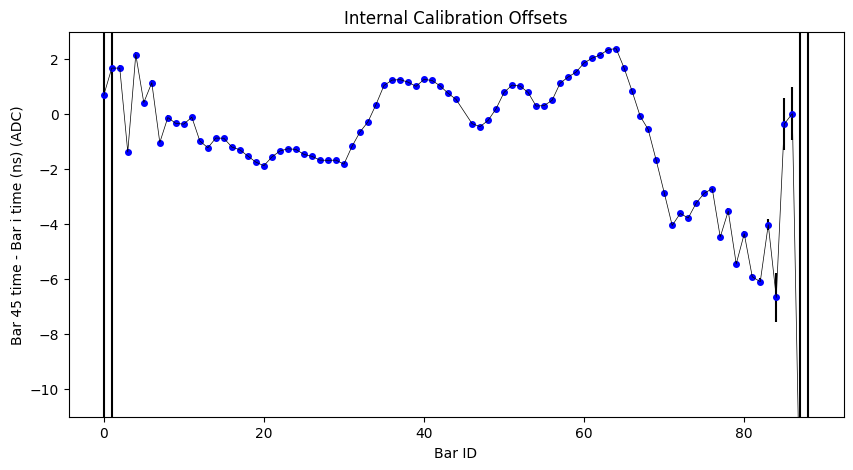

In [293]:
lw=1
plt.figure(figsize=(10,5))
result=np.array(id_offset)
result=np.transpose(result)
plt.errorbar(result[0],result[1],result[2],ls='none',color='black',lw=lw*1.5)

plt.plot(result[0],result[1],'.',color='blue',markersize=8)
plt.plot(result[0],result[1],color='black',lw=lw/2)

plt.xlabel('Bar ID')
plt.ylabel('Bar 45 time - Bar i time (ns) (ADC)')
plt.title('Internal Calibration Offsets')
plt.ylim(-11,3)

(-11.0, 3.0)

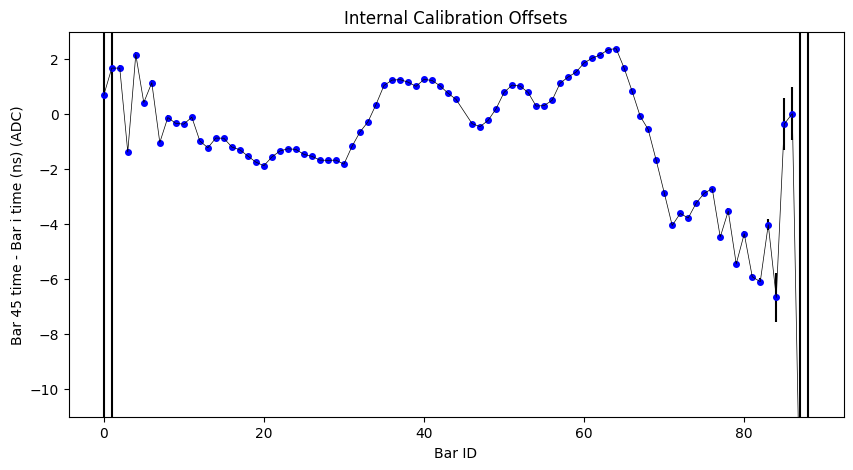

In [295]:
lw=1
plt.figure(figsize=(10,5))
result=np.array(id_offset)
result=np.transpose(result)
plt.errorbar(result[0],result[1],result[2],ls='none',color='black',lw=lw*1.5)

plt.plot(result[0],result[1],'.',color='blue',markersize=8)
plt.plot(result[0],result[1],color='black',lw=lw/2)

plt.xlabel('Bar ID')
plt.ylabel('Bar 45 time - Bar i time (ns) (ADC)')
plt.title('Internal Calibration Offsets')
plt.ylim(-11,3)

In [296]:
first_array=result[0]
second_array=result[1]

insert_index = np.searchsorted(first_array, 45)

first_array = np.insert(first_array, insert_index, 45)

second_array = np.insert(second_array, insert_index, 0)
new_offset=np.nan_to_num(second_array, nan=0)
np.save("TDCOffsetHodo.npy",new_offset)


np.round(new_offset,4)

array([ 6.88400e-01,  1.67730e+00,  1.67730e+00, -1.37360e+00,
        2.17140e+00,  4.23600e-01,  1.14570e+00, -1.03010e+00,
       -1.20200e-01, -3.34300e-01, -3.60300e-01, -1.08200e-01,
       -9.71400e-01, -1.21980e+00, -8.66400e-01, -8.72800e-01,
       -1.19270e+00, -1.29370e+00, -1.52090e+00, -1.74290e+00,
       -1.87240e+00, -1.55620e+00, -1.33650e+00, -1.25670e+00,
       -1.27980e+00, -1.46010e+00, -1.53060e+00, -1.66810e+00,
       -1.67740e+00, -1.66950e+00, -1.81600e+00, -1.17350e+00,
       -6.48100e-01, -2.77800e-01,  3.48600e-01,  1.04520e+00,
        1.24040e+00,  1.25830e+00,  1.16800e+00,  1.01390e+00,
        1.26370e+00,  1.22990e+00,  1.03300e+00,  7.63300e-01,
        5.40400e-01,  0.00000e+00, -3.41300e-01, -4.50900e-01,
       -2.26600e-01,  1.98100e-01,  7.93400e-01,  1.05840e+00,
        1.02430e+00,  7.91200e-01,  2.97000e-01,  3.13200e-01,
        5.06400e-01,  1.12750e+00,  1.35180e+00,  1.53350e+00,
        1.86490e+00,  2.03850e+00,  2.15760e+00,  2.349

(array([ 0.,  0.,  3.,  5.,  7., 20., 22., 25.,  5.,  0.]),
 array([-10. ,  -8.5,  -7. ,  -5.5,  -4. ,  -2.5,  -1. ,   0.5,   2. ,
          3.5,   5. ]),
 <BarContainer object of 10 artists>)

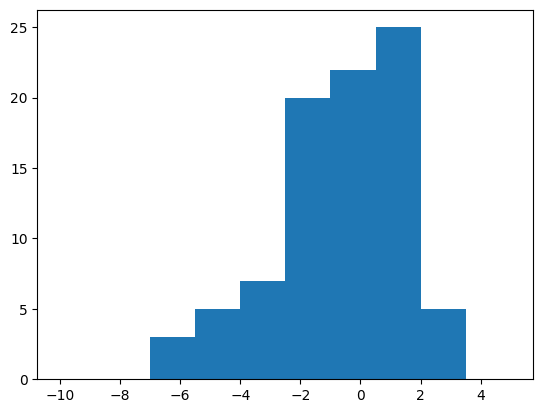

In [298]:
plt.hist(new_offset,range=(-10,5))

In [231]:


def Load_HodoNew(config):
    rootfile = f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
    #rootfile = f"../outfiles/oldhcal.root"
    rootfile2=f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_p_model1.root"
    C = r.TChain("Tout")
    C.Add(rootfile)
    C.SetBranchStatus("*", 0)
   
    
    #HCAL VARS_____________________________________
    #HCAL VARS_____________________________________
    C.SetBranchStatus("cx", 1)
    C.SetBranchStatus("cy", 1)
    C.SetBranchStatus("cblktime",1)
    C.SetBranchStatus("cblkatime",1)
    C.SetBranchStatus("cblkid",1)
    C.SetBranchStatus("cblke",1)
    C.SetBranchStatus("tdc",1)
    C.SetBranchStatus("atime",1)
    C.SetBranchStatus("bbcal_time",1)
    C.SetBranchStatus("pblkid",1)
    C.SetBranchStatus("nclus",1)
    C.SetBranchStatus("nblk",1)
    #C.SetBranchStatus("hodoTOT",1)
    
    bbtime=array.array('d',[0])
    tdc=array.array('d',[0])
    atime=array.array('d',[0])
    pblkid=array.array('d',[0])
    cx = array.array('d', [0]*10) 
    cy = array.array('d', [0]*10) 
    cblktime=array.array('d',[0]*25)
    cblkatime=array.array('d',[0]*25)
    cblkid=array.array('d',[0]*25)
    cblke=array.array('d',[0]*25)
    nclus=array.array('d',[0])
    nblk=array.array('i',[0])
    #hodoTOT=array.array('d',[0]*6)
    
    
    C.SetBranchAddress("cx", cx)
    C.SetBranchAddress("cy", cy)
    C.SetBranchAddress("cblktime",cblktime)
    C.SetBranchAddress("cblkatime",cblkatime)
    C.SetBranchAddress("cblkid",cblkid)
    C.SetBranchAddress("cblke",cblke)
    C.SetBranchAddress("tdc",tdc)
    C.SetBranchAddress("atime",atime)
    C.SetBranchAddress("pblkid",pblkid)
    C.SetBranchAddress("bbcal_time",bbtime)
    C.SetBranchAddress("nclus",nclus)
    C.SetBranchAddress("nblk",nblk)

    #_____________________________________
    
    
    #CUT VARS_____________________________________
    C.SetBranchStatus("W2",1)
    C.SetBranchStatus("dx",1)
    C.SetBranchStatus("dy",1)
    
    W2=array.array('d',[0])
    dx=array.array('d',[0])
    dy=array.array('d',[0])
    
    C.SetBranchAddress("W2",W2)
    C.SetBranchAddress("dx",dx)
    C.SetBranchAddress("dy",dy)
    
    #_____________________________________
    
    cx_array=[]
    cy_array=[]
    cblktime_array=[]
    cblkatime_array=[]
    cblkid_array=[]
    cblke_array=[]
    tdc_array=[]
    bbtime_array=[]
    atime_array=[]
    pblkid_array=[]
    target=[]
    weighted_time=[]
    
    C.GetEntry(0)
    Entries=C.GetEntries()
    passedcut=0
    for i in range(0,Entries):
        
        C.GetEntry(i)
           
        #cut----------------
        wcut=W2min<W2[0]<W2max
        dxcut=dxmin<dx[0]<dxmax
        dycut=dymin<dy[0]<dymax
        cut=wcut and dxcut and dycut
        cut = wcut and dycut
        #-------------------
        
        if cut:
            try:
                
                # Amplitude weighted time
                
                        #adjust offsets of blocks affected
                for i in range(0,len(cblkid[:nblk[0]])):
                    cblktime[i]=cblktime[i]-old_offset[int(cblkid[i])-1]+final_offset[int(cblkid[i])-1]
                
                #print(cblke[:nblk[0]])
                
                npENERGY=np.array(cblke[:nblk[0]])
                npTIME=np.array(cblktime[:nblk[0]])
                weighted_time.append(np.sum(npENERGY*npTIME)/np.sum(npENERGY))
           
                
                
                
                
                
                
                # Amplitude weighted time
                
                
                tdc_array.append(tdc[0]-old_offset[int(pblkid[0]-1)]+final_offset[int(pblkid[0]-1)])
                
                #atime_array.append(atime[0]-old_offsetADC[int(pblkid[0]-1)]+final_offsetADC[int(pblkid[0]-1)])
                bbtime_array.append(bbtime[0])
                passedcut+=1
                cx_array.append(cx)
                cy_array.append(cy)
                
                pblkid_array.append(pblkid[0])
                cblktime_array.append(cblktime)
                cblkatime_array.append(cblkatime)

                cblkid_array.append(cblkid)
                cblke_array.append(cblke)
                target.append(0)
            except:
                print("Error with event")
    
    
    
    
    
   
    HCalArrays=[cx_array,cy_array,cblktime_array,cblkid_array,cblke_array,tdc_array,pblkid_array,cblkatime_array
                ,"atime_array",target,bbtime_array,weighted_time]
    return HCalArrays

# To run the function
